# Long-Short Strategy, Part 3: Evaluating our Boosting Model Signals

In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. [preparing_the_model_data](04_preparing_the_model_data.ipyny): we engineer a few simple features from the Quandl Wiki data 
2. [trading_signals_with_lightgbm_and_catboost](05_trading_signals_with_lightgbm_and_catboost.ipynb): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. `evaluate_trading_signals` (this noteboook): we compare the cross-validation performance using various metrics to select the best model. 
4. [model_interpretation](07_model_interpretation.ipynb): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb): we generate predictions for our out-of-sample test period 2017.
6. [backtesting_with_zipline](09_backtesting_with_zipline.ipynb): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

Cross-validation of numerous configurations has produced a large number of results. Now, we need to evaluate the predictive performance to identify the model that generates the most reliable and profitable signals for our prospective trading strategy.

Se toman los daily (en nuestro caso weekly) coeficientes de información, como el mejor indicador y no los totales.

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from time import time
from io import StringIO
import sys, os
import warnings
from pathlib import Path
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from scipy.stats import spearmanr, pearsonr

from alphalens import plotting
from alphalens import performance as perf
from alphalens.utils import get_clean_factor_and_forward_returns, rate_of_return, std_conversion
from alphalens.tears import (create_summary_tear_sheet,
                             create_full_tear_sheet)

In [3]:
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import MultipleTimeSeriesCV

In [9]:
sns.set_style('whitegrid')

In [5]:
#YEAR = 252
#YEAR = 12
idx = pd.IndexSlice

In [6]:
scope_params = ['lookahead', 'train_length', 'test_length']
daily_ic_metrics = ['daily_ic_mean', 'daily_ic_mean_n', 'daily_ic_median', 'daily_ic_median_n']
lgb_train_params = ['learning_rate', 'num_leaves', 'feature_fraction', 'min_data_in_leaf']
rf_train_params = ['bagging_fraction', 'feature_fraction', 'min_data_in_leaf','max_depth']
catboost_train_params = ['max_depth', 'min_child_samples']

In [7]:
results_path = Path('results', 'us_stocks')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [8]:
results_path

PosixPath('results/us_stocks')

## Collect Data

We produced a larger number of LightGBM models because it runs an order of magnitude faster than CatBoost and will demonstrate some evaluation strategies accordingly.

### LightGBM

#### Summary Metrics by Fold

First, we collect the summary metrics computed for each fold and hyperparameter combination:

In [10]:
results_path

PosixPath('results/us_stocks')

In [11]:
with pd.HDFStore(results_path / 'tuning_lgb.h5') as store:
    for i, key in enumerate(
        [k[1:] for k in store.keys() if k[1:].startswith('metrics')]):
        _, t, train_length, test_length = key.split('/')[:4]
        attrs = {
            'lookahead': t,
            'train_length': train_length,
            'test_length': test_length
        }
        s = store[key].to_dict()
        s.update(attrs)
        if i == 0:
            lgb_metrics = pd.Series(s).to_frame(i)
        else:
            lgb_metrics[i] = pd.Series(s)

# lgb_metrics = pd.read_parquet(results_path / 'tuning_lgb.parquet', engine='fastparquet')

id_vars = scope_params + lgb_train_params + daily_ic_metrics
lgb_metrics = pd.melt(lgb_metrics.T.drop('t', axis=1), 
                  id_vars=id_vars, 
                  value_name='ic', 
                  var_name='boost_rounds').dropna().apply(pd.to_numeric)

In [14]:
lgb_metrics.sort_values(by='ic', ascending=False)

lookahead  train_length  test_length  learning_rate  num_leaves  \
170          1           520            1            0.3         4.0   
116          1           520            1            0.3         4.0   
239          1           520            1            0.1         4.0   
185          1           520            1            0.1         4.0   
55           1           520            1            0.3         8.0   
..         ...           ...          ...            ...         ...   
137          1           520            1            0.1       128.0   
83           1           520            1            0.1       128.0   
22           1           520            1            0.1         4.0   
29           1           520            1            0.1       128.0   
76           1           520            1            0.1         4.0   

     feature_fraction  min_data_in_leaf  daily_ic_mean  daily_ic_mean_n  \
170              0.60             500.0       0.077242             75.0   
116              0.60             500.0       0.077242             75.0   
239              0.60             500.0       0.058329            300.0   
185              0.60             500.0       0.058329            300.0   
55               0.95             500.0       0.050594             25.0   
..                ...               ...            ...              ...   
137              0.60             250.0       0.076736             10.0   
83               0.60             250.0       0.076736             10.0   
22               0.60             250.0       0.053446             75.0   
29               0.60             250.0       0.076736             10.0   
76               0.60             250.0       0.053446             75.0   

     daily_ic_median  daily_ic_median_n  boost_rounds        ic  
170         0.090909              150.0            75  0.109012  
116         0.090909              150.0            50  0.106660  
239         0.093070               50.0           100  0.100400  
185         0.093070               50.0            75  0.097464  
55          0.078904               25.0            25  0.097081  
..               ...                ...           ...       ...  
137         0.100226               10.0            50 -0.053585  
83          0.100226               10.0            25 -0.060953  
22          0.074620               75.0            10 -0.067386  
29          0.100226               10.0            10 -0.070959  
76          0.074620               75.0            25 -0.075205  

[702 rows x 13 columns]

In [12]:
#print(os.getcwd())

In [15]:
lgb_metrics.to_hdf('data/model_tuning.h5', 'lgb/metrics')
lgb_metrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          702 non-null    int64  
 1   train_length       702 non-null    int64  
 2   test_length        702 non-null    int64  
 3   learning_rate      702 non-null    float64
 4   num_leaves         702 non-null    float64
 5   feature_fraction   702 non-null    float64
 6   min_data_in_leaf   702 non-null    float64
 7   daily_ic_mean      702 non-null    float64
 8   daily_ic_mean_n    702 non-null    float64
 9   daily_ic_median    702 non-null    float64
 10  daily_ic_median_n  702 non-null    float64
 11  boost_rounds       702 non-null    int64  
 12  ic                 702 non-null    float64
dtypes: float64(9), int64(4)
memory usage: 71.4 KB


In [16]:
lgb_metrics.groupby(scope_params).size()

lookahead  train_length  test_length
1          520           1              702
dtype: int64

#### Information Coefficient by Day

Next, we retrieve the IC per day computed during cross-validation:

In [17]:
int_cols = ['lookahead', 'train_length', 'test_length', 'boost_rounds']

In [18]:
lgb_ic = []
with pd.HDFStore(results_path / 'tuning_lgb.h5') as store:
    keys = [k[1:] for k in store.keys()]
    for key in keys:
        _, t, train_length, test_length = key.split('/')[:4]
        if key.startswith('daily_ic'):
            df = (store[key]
                  .drop(['boosting', 'objective', 'verbose'], axis=1)
                 .assign(lookahead=t, 
                         train_length=train_length, 
                         test_length=test_length))
            lgb_ic.append(df)
    lgb_ic = pd.concat(lgb_ic).reset_index()

In [19]:
lgb_ic

date        10        25        50        75       100       150  \
0     2017-01-08  0.586094  0.742599  0.763636  0.663636  0.609091  0.609091   
1     2017-01-15  0.447214  0.181878  0.054545  0.000000  0.009091  0.109091   
2     2017-01-22  0.079211  0.651404  0.500000  0.572727  0.709091  0.663636   
3     2017-01-29 -0.117219 -0.023318  0.009133 -0.050114  0.090909  0.118182   
4     2017-02-05 -0.402573  0.064439  0.220193  0.090909  0.345455  0.554545   
...          ...       ...       ...       ...       ...       ...       ...   
11227 2020-11-29       NaN -0.067420 -0.115624  0.102353  0.018265  0.190909   
11228 2020-12-06  0.748534  0.227791  0.036364  0.000000  0.227273  0.327273   
11229 2020-12-13  0.443946  0.600000  0.518182  0.536364  0.663636  0.718182   
11230 2020-12-20 -0.520941 -0.537587 -0.436364 -0.300000 -0.354545 -0.463636   
11231 2020-12-27  0.331271  0.193567  0.059226  0.072727  0.000000  0.054545   

            200       250       300  ...       400       450       500  \
0      0.690909  0.690909  0.672727  ...  0.718182  0.718182  0.790909   
1      0.045455  0.027273  0.109091  ...  0.063636  0.090909  0.036364   
2      0.654545  0.554545  0.618182  ...  0.554545  0.554545  0.490909   
3      0.154545  0.000000 -0.045455  ... -0.136364 -0.072727  0.027273   
4      0.418182  0.345455  0.227273  ...  0.327273  0.190909  0.245455   
...         ...       ...       ...  ...       ...       ...       ...   
11227  0.009091 -0.027273  0.118182  ...  0.136364  0.109091  0.145455   
11228  0.445455  0.445455  0.527273  ...  0.554545  0.545455  0.545455   
11229  0.718182  0.718182  0.718182  ...  0.690909  0.690909  0.700000   
11230 -0.509091 -0.509091 -0.636364  ... -0.672727 -0.581818 -0.554545   
11231  0.018182  0.018182  0.045455  ...  0.045455  0.045455  0.045455   

       learning_rate  num_leaves  feature_fraction  min_data_in_leaf  \
0               0.30           8              0.95              1000   
1               0.30           8              0.95              1000   
2               0.30           8              0.95              1000   
3               0.30           8              0.95              1000   
4               0.30           8              0.95              1000   
...              ...         ...               ...               ...   
11227           0.01         128              0.30               500   
11228           0.01         128              0.30               500   
11229           0.01         128              0.30               500   
11230           0.01         128              0.30               500   
11231           0.01         128              0.30               500   

       lookahead train_length test_length  
0              1          520           1  
1              1          520           1  
2              1          520           1  
3              1          520           1  
4              1          520           1  
...          ...          ...         ...  
11227          1          520           1  
11228          1          520           1  
11229          1          520           1  
11230          1          520           1  
11231          1          520           1  

[11232 rows x 21 columns]

In [20]:
id_vars = ['date'] + scope_params + lgb_train_params
lgb_ic = pd.melt(lgb_ic, 
                 id_vars=id_vars, 
                 value_name='ic', 
                 var_name='boost_rounds').dropna()
lgb_ic.loc[:, int_cols] = lgb_ic.loc[:, int_cols].astype(int)

In [21]:
lgb_ic.to_hdf('data/model_tuning.h5', 'lgb/ic')
lgb_ic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 135237 entries, 0 to 146015
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   date              135237 non-null  datetime64[ns]
 1   lookahead         135237 non-null  object        
 2   train_length      135237 non-null  object        
 3   test_length       135237 non-null  object        
 4   learning_rate     135237 non-null  float64       
 5   num_leaves        135237 non-null  int64         
 6   feature_fraction  135237 non-null  float64       
 7   min_data_in_leaf  135237 non-null  int64         
 8   boost_rounds      135237 non-null  object        
 9   ic                135237 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(4)
memory usage: 11.3+ MB


In [22]:
lgb_daily_ic = lgb_ic.groupby(id_vars[1:] + ['boost_rounds']).ic.mean().to_frame('ic').reset_index()
lgb_daily_ic.to_hdf('data/model_tuning.h5', 'lgb/daily_ic')
lgb_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701 entries, 0 to 700
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         701 non-null    int64  
 1   train_length      701 non-null    int64  
 2   test_length       701 non-null    int64  
 3   learning_rate     701 non-null    float64
 4   num_leaves        701 non-null    int64  
 5   feature_fraction  701 non-null    float64
 6   min_data_in_leaf  701 non-null    int64  
 7   boost_rounds      701 non-null    int64  
 8   ic                701 non-null    float64
dtypes: float64(3), int64(6)
memory usage: 49.4 KB


In [23]:
lgb_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/ic')
lgb_daily_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/daily_ic')

### Random Forest

We proceed similarly for Random forest

#### Summary Metrics by Fold

First, we collect the summary metrics computed for each fold and hyperparameter combination:

In [51]:
with pd.HDFStore(results_path / 'tuning_lgb.h5') as store:
    for i, key in enumerate(
        [k[1:] for k in store.keys() if k[1:].startswith('metrics')]):
        _, t, train_length, test_length = key.split('/')[:4]
        attrs = {
            'lookahead': t,
            'train_length': train_length,
            'test_length': test_length
        }
        s = store[key].to_dict()
        s.update(attrs)
        if i == 0:
            rf_metrics = pd.Series(s).to_frame(i)
        else:
            rf_metrics[i] = pd.Series(s)

id_vars = scope_params + rf_train_params + daily_ic_metrics
rf_metrics = pd.melt(rf_metrics.T.drop('t', axis=1), 
                  id_vars=id_vars, 
                  value_name='ic', 
                  var_name='boost_rounds').dropna().apply(pd.to_numeric)

KeyError: "The following id_vars or value_vars are not present in the DataFrame: ['bagging_fraction', 'max_depth']"

In [20]:
#print(os.getcwd())

In [21]:
id_vars

['lookahead',
 'train_length',
 'test_length',
 'bagging_fraction',
 'feature_fraction',
 'min_data_in_leaf',
 'max_depth',
 'daily_ic_mean',
 'daily_ic_mean_n',
 'daily_ic_median',
 'daily_ic_median_n']

In [22]:
import pandas as pd

# Abre el archivo HDF5
store = pd.HDFStore(results_path / 'tuning_rf.h5')

# Imprime las claves
for key in store.keys():
    print(key)

# No olvides cerrar el archivo HDF5 cuando hayas terminado
store.close()


/predictions/1/52/12/0.95/0.95/74/10
/predictions/1/52/12/0.95/0.95/74/5
/predictions/1/52/12/0.95/0.95/100/-1
/predictions/1/52/12/0.95/0.95/100/5
/predictions/1/52/12/0.95/0.75/74/10
/predictions/1/52/12/0.95/0.75/74/5
/predictions/1/52/12/0.95/0.75/200/-1
/predictions/1/52/12/0.95/0.75/100/10
/predictions/1/52/12/0.95/0.75/100/5
/predictions/1/52/12/0.75/0.95/74/-1
/predictions/1/52/12/0.75/0.95/200/10
/predictions/1/52/12/0.75/0.95/200/5
/predictions/1/52/12/0.75/0.95/100/-1
/predictions/1/52/12/0.75/0.95/100/10
/predictions/1/52/12/0.75/0.75/74/10
/predictions/1/52/12/0.75/0.75/74/5
/predictions/1/52/12/0.75/0.75/200/10
/predictions/1/52/12/0.75/0.75/100/-1
/predictions/1/52/1/0.95/0.95/200/-1
/predictions/1/52/1/0.95/0.95/200/5
/predictions/1/52/1/0.95/0.95/100/10
/predictions/1/52/1/0.95/0.95/100/5
/predictions/1/52/1/0.95/0.75/74/5
/predictions/1/52/1/0.95/0.75/200/10
/predictions/1/52/1/0.95/0.75/100/-1
/predictions/1/52/1/0.95/0.75/100/10
/predictions/1/52/1/0.95/0.75/100/5
/

In [23]:
rf_metrics.to_hdf('data/model_tuning.h5', 'rf/metrics')
rf_metrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lookahead          144 non-null    int64  
 1   train_length       144 non-null    int64  
 2   test_length        144 non-null    int64  
 3   bagging_fraction   144 non-null    float64
 4   feature_fraction   144 non-null    float64
 5   min_data_in_leaf   144 non-null    float64
 6   max_depth          144 non-null    float64
 7   daily_ic_mean      144 non-null    float64
 8   daily_ic_mean_n    144 non-null    float64
 9   daily_ic_median    144 non-null    float64
 10  daily_ic_median_n  144 non-null    float64
 11  boost_rounds       144 non-null    int64  
 12  ic                 144 non-null    float64
dtypes: float64(9), int64(4)
memory usage: 15.8 KB


In [24]:
rf_metrics.groupby(scope_params).size()

lookahead  train_length  test_length
1          52            1              36
                         12             36
           216           1              36
                         12             36
dtype: int64

#### Information Coefficient by Day

Next, we retrieve the IC per day computed during cross-validation:

In [25]:
int_cols = ['lookahead', 'train_length', 'test_length', 'boost_rounds']

In [26]:
rf_ic = []
with pd.HDFStore(results_path / 'tuning_rf.h5') as store:
    keys = [k[1:] for k in store.keys()]
    for key in keys:
        _, t, train_length, test_length = key.split('/')[:4]
        if key.startswith('daily_ic'):
            if {'boosting_type', 'objective', 'verbose'}.issubset(store[key].columns):
                df = (store[key]
                  .drop(['boosting_type', 'objective', 'verbose'], axis=1)
                  .assign(lookahead=t, 
                 train_length=train_length, 
                 test_length=test_length))
                rf_ic.append(df)
            else:
    
                df = (store[key]
                       .assign(lookahead=t, 
                         train_length=train_length, 
                         test_length=test_length))
                rf_ic.append(df)
    rf_ic = pd.concat(rf_ic).reset_index()

In [27]:
#borramos bagging freq
rf_ic=rf_ic.drop(['bagging_freq'], axis=1)

In [28]:
rf_ic

date        50       100  bagging_fraction  feature_fraction  \
0     2013-01-13       NaN       NaN              0.95              0.95   
1     2013-01-20       NaN       NaN              0.95              0.95   
2     2013-01-27       NaN -0.776899              0.95              0.95   
3     2013-02-03       NaN       NaN              0.95              0.95   
4     2013-02-10       NaN       NaN              0.95              0.95   
...          ...       ...       ...               ...               ...   
22459 2018-12-02  0.175882  0.175882              0.75              0.75   
22460 2018-12-09 -0.119523 -0.119523              0.75              0.75   
22461 2018-12-16  0.040452  0.040452              0.75              0.75   
22462 2018-12-23       NaN -0.101929              0.75              0.75   
22463 2018-12-30 -0.448863 -0.348452              0.75              0.75   

       min_data_in_leaf  max_depth lookahead train_length test_length  
0                    74         10         1           52          12  
1                    74         10         1           52          12  
2                    74         10         1           52          12  
3                    74         10         1           52          12  
4                    74         10         1           52          12  
...                 ...        ...       ...          ...         ...  
22459               100          5         1          216           1  
22460               100          5         1          216           1  
22461               100          5         1          216           1  
22462               100          5         1          216           1  
22463               100          5         1          216           1  

[22464 rows x 10 columns]

In [29]:
id_vars = ['date'] + scope_params + rf_train_params
rf_ic = pd.melt(rf_ic, 
                 id_vars=id_vars, 
                 value_name='ic', 
                 var_name='boost_rounds').dropna()
rf_ic.loc[:, int_cols] = rf_ic.loc[:, int_cols].astype(int)

In [30]:
rf_train_params

['bagging_fraction', 'feature_fraction', 'min_data_in_leaf', 'max_depth']

In [31]:
rf_ic.to_hdf('data/model_tuning.h5', 'rf/ic')
rf_ic.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37701 entries, 12 to 44927
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   date              37701 non-null  datetime64[ns]
 1   lookahead         37701 non-null  int32         
 2   train_length      37701 non-null  int32         
 3   test_length       37701 non-null  int32         
 4   bagging_fraction  37701 non-null  float64       
 5   feature_fraction  37701 non-null  float64       
 6   min_data_in_leaf  37701 non-null  int64         
 7   max_depth         37701 non-null  int64         
 8   boost_rounds      37701 non-null  int32         
 9   ic                37701 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int32(4), int64(2)
memory usage: 2.6 MB


In [32]:
rf_daily_ic = rf_ic.groupby(id_vars[1:] + ['boost_rounds']).ic.mean().to_frame('ic').reset_index()
rf_daily_ic.to_hdf('data/model_tuning.h5', 'rf/daily_ic')
rf_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         144 non-null    int64  
 1   train_length      144 non-null    int64  
 2   test_length       144 non-null    int64  
 3   bagging_fraction  144 non-null    float64
 4   feature_fraction  144 non-null    float64
 5   min_data_in_leaf  144 non-null    int64  
 6   max_depth         144 non-null    int64  
 7   boost_rounds      144 non-null    int64  
 8   ic                144 non-null    float64
dtypes: float64(3), int64(6)
memory usage: 10.2 KB


In [33]:
rf_ic = pd.read_hdf('data/model_tuning.h5', 'rf/ic')
rf_daily_ic = pd.read_hdf('data/model_tuning.h5', 'rf/daily_ic')

## Validation Performance: Daily vs Overall Information Coefficient

The following image shows that that LightGBM (in orange) performs (slightly) better than CatBoost, especially for longer horizons. This is not an entirely fair comparison because we ran more configurations for LightGBM, which also, unsurprisingly, shows a wider dispersion of outcomes:


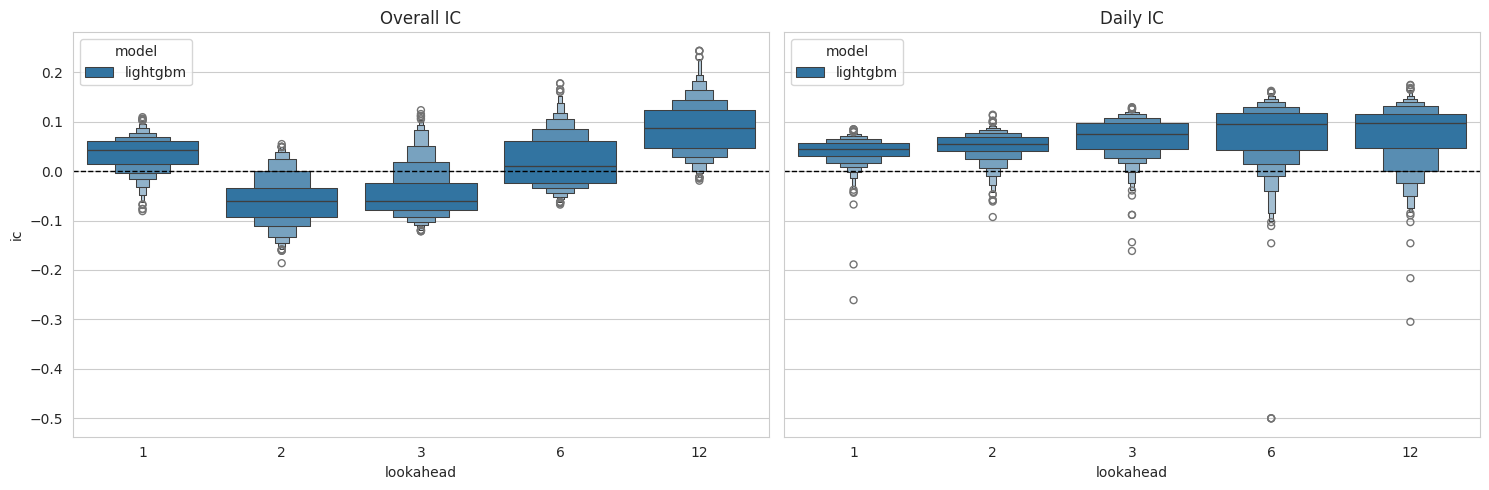

In [30]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)
sns.boxenplot(x='lookahead', y='ic', hue='model',
              data=pd.concat([lgb_metrics.assign(model='lightgbm'),
                            ]), ax=axes[0])
axes[0].axhline(0, ls='--', lw=1, c='k')
axes[0].set_title('Overall IC')
sns.boxenplot(x='lookahead', y='ic', hue='model',
              data=pd.concat([lgb_daily_ic.assign(model='lightgbm'),
                            ]), ax=axes[1])
axes[1].axhline(0, ls='--', lw=1, c='k')
axes[1].set_title('Daily IC')
fig.tight_layout()

## HyperParameter Impact: Linear Regression

Next, we'd like to understand if there's a systematic, statistical relationship between the hyperparameters and the outcomes across daily predictions. To this end, we will run a linear regression using the various LightGBM hyperparameter settings as dummy variables and the daily validation IC as the outcome.

The below chart shows the coefficient estimates and their confidence intervals for 1- and 21-day forecast horizons (1 y 2 horizonte mensual en nuestro caso). 
- For the shorter horizon, a longer lookback period, a higher learning rate, and deeper trees (more leaf nodes) have a positive impact. 
- For the longer horizon, the picture is a little less clear: shorter trees do better, but the lookback period is not significant. A higher feature sampling rate also helps. In both cases, a larger ensemble does better. 

Note that these results apply to this specific example only.

In [37]:
X.values

array([[1.0, False, False, ..., False, False, False],
       [1.0, True, False, ..., False, False, False],
       [1.0, False, True, ..., False, False, False],
       ...,
       [1.0, False, False, ..., False, False, True],
       [1.0, False, False, ..., False, False, True],
       [1.0, False, False, ..., False, False, True]], dtype=object)

In [33]:
type(y)


pandas.core.series.Series

In [38]:
lin_reg = {}
#for t in [1, 2]: #si hay 2 lookaheads
for t in [1]:
    df_ = lgb_ic[lgb_ic.lookahead==t]
    y, X = df_.ic, df_.drop(['ic'], axis=1)
    X = sm.add_constant(pd.get_dummies(X, columns=X.columns, drop_first=True))
    model = sm.OLS(endog=y.values, exog=X.astype(float).values)
    lin_reg[t] = model.fit()
    s = lin_reg[t].summary()
    coefs = pd.read_csv(StringIO(s.tables[1].as_csv())).rename(columns=lambda x: x.strip())
    coefs.columns = ['variable', 'coef', 'std_err', 't', 'p_value', 'ci_low', 'ci_high']
    coefs.to_csv(f'results/linreg_result_{t:02}.csv', index=False)

In [49]:
def visualize_lr_result(model, ax):
    ci = model.conf_int().reshape(2,-1)
    errors = pd.Series(ci[1]).sub(pd.Series(ci[0])).div(2)

    coefs = (pd.Series(model.params).to_frame('coef').assign(error=errors)
             .reset_index().rename(columns={'index': 'variable'}))
    coefs = coefs[~coefs['variable'].str.startswith('date')&(coefs.variable!='const')]

    coefs.plot(x='variable', y='coef', kind='bar', 
                 ax=ax, color='none', capsize=3,
                 yerr='error', legend=False)
    ax.set_ylabel('IC')
    ax.set_xlabel('')
    ax.scatter(x=pd.np.arange(len(coefs)), marker='_', s=120, y=coefs['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
    ax.xaxis.set_ticks_position('none')

AttributeError: Can only use .str accessor with string values!

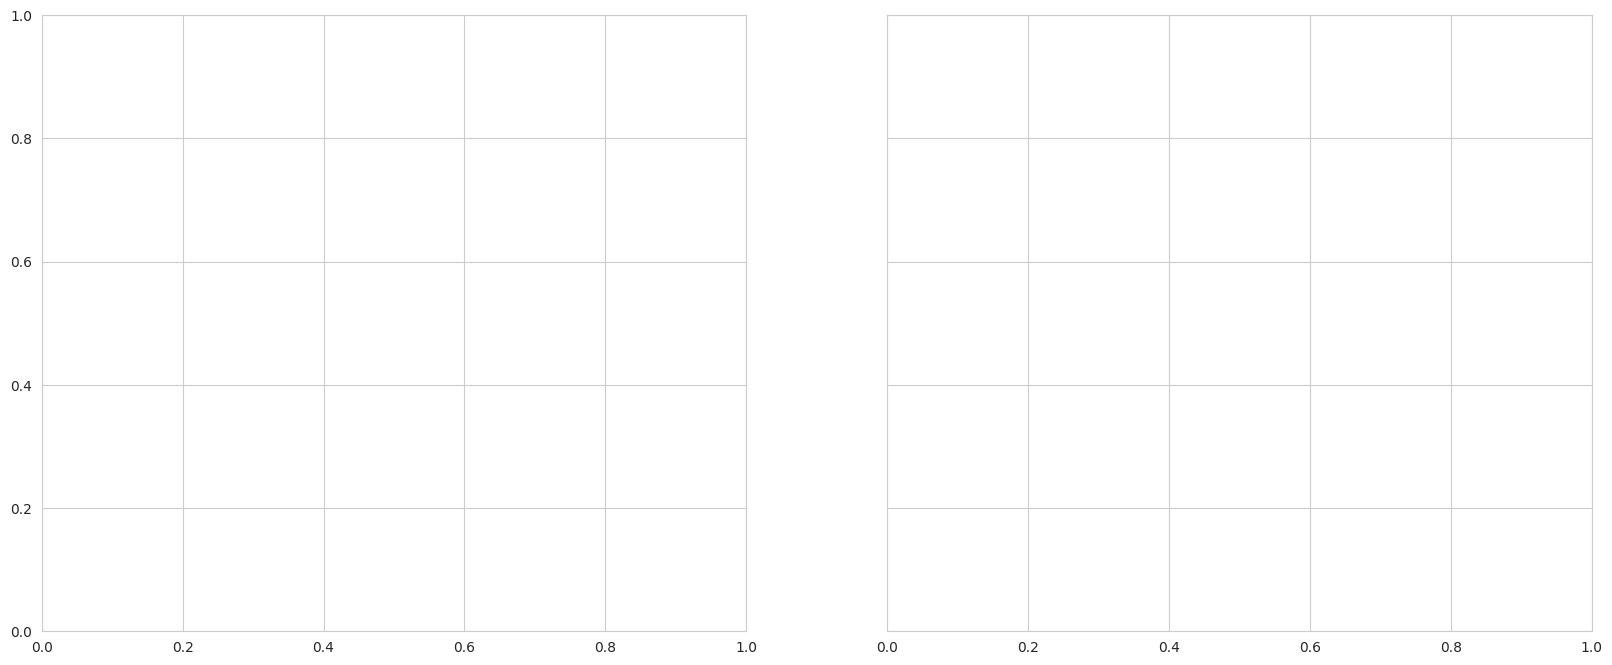

In [50]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True)
axes = axes.flatten()
#for i, t in enumerate([1, 2]):#modificado
for i, t in enumerate([1]):#modificado un lookahead
    visualize_lr_result(lin_reg[t], axes[i])
    axes[i].set_title(f'Lookahead: {t} Day(s)')
fig.suptitle('OLS Coefficients & Confidence Intervals', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.92);

# Lo mismo para RF

In [38]:
lin_reg = {}
#for t in [1, 2]:
for t in [1]:
    df_ = rf_ic[rf_ic.lookahead==t]
    y, X = df_.ic, df_.drop(['ic'], axis=1)
    #X = sm.add_constant(pd.get_dummies(X, columns=X.columns, drop_first=True))
    X = sm.add_constant(pd.get_dummies(X, columns=X.columns))
    model = sm.OLS(endog=y, exog=X)
    lin_reg[t] = model.fit()
    s = lin_reg[t].summary()
    coefs = pd.read_csv(StringIO(s.tables[1].as_csv())).rename(columns=lambda x: x.strip())
    coefs.columns = ['variable', 'coef', 'std_err', 't', 'p_value', 'ci_low', 'ci_high']
    coefs.to_csv(f'results/linreg_result_{t:02}.csv', index=False)

In [39]:
 X

date_2013-01-13 00:00:00  date_2013-01-20 00:00:00  \
12                            0                         0   
13                            0                         0   
14                            0                         0   
15                            0                         0   
16                            0                         0   
...                         ...                       ...   
44923                         0                         0   
44924                         0                         0   
44925                         0                         0   
44926                         0                         0   
44927                         0                         0   

       date_2013-01-27 00:00:00  date_2013-02-03 00:00:00  \
12                            0                         0   
13                            0                         0   
14                            0                         0   
15                            0                         0   
16                            0                         0   
...                         ...                       ...   
44923                         0                         0   
44924                         0                         0   
44925                         0                         0   
44926                         0                         0   
44927                         0                         0   

       date_2013-02-10 00:00:00  date_2013-02-17 00:00:00  \
12                            0                         0   
13                            0                         0   
14                            0                         0   
15                            0                         0   
16                            0                         0   
...                         ...                       ...   
44923                         0                         0   
44924                         0                         0   
44925                         0                         0   
44926                         0                         0   
44927                         0                         0   

       date_2013-02-24 00:00:00  date_2013-03-03 00:00:00  \
12                            0                         0   
13                            0                         0   
14                            0                         0   
15                            0                         0   
16                            0                         0   
...                         ...                       ...   
44923                         0                         0   
44924                         0                         0   
44925                         0                         0   
44926                         0                         0   
44927                         0                         0   

       date_2013-03-10 00:00:00  date_2013-03-17 00:00:00  ...  \
12                            0                         0  ...   
13                            0                         0  ...   
14                            0                         0  ...   
15                            0                         0  ...   
16                            0                         0  ...   
...                         ...                       ...  ...   
44923                         0                         0  ...   
44924                         0                         0  ...   
44925                         0                         0  ...   
44926                         0                         0  ...   
44927                         0                         0  ...   

       feature_fraction_0.75  feature_fraction_0.95  min_data_in_leaf_74  \
12                         0                      1                    1   
13                         0                      1                    1   
14                         0                      1   

In [40]:
coefs.tail(20)

variable    coef  std_err      t  p_value    ci_low  \
309  date_2018-12-16 00:00:00  0.0556    0.029  1.888    0.059 -0.002000   
310  date_2018-12-23 00:00:00 -0.0422    0.046 -0.908    0.364 -0.133000   
311  date_2018-12-30 00:00:00 -0.0764    0.038 -2.035    0.042 -0.150000   
312  lookahead_1              -0.0005    0.000 -1.228    0.220 -0.001000   
313  train_length_52          -0.0068    0.002 -3.971    0.000 -0.010000   
314  train_length_216          0.0063    0.002  3.802    0.000  0.003000   
315  test_length_1            -0.0036    0.002 -2.214    0.027 -0.007000   
316  test_length_12            0.0031    0.002  1.904    0.057 -0.000092   
317  bagging_fraction_0.75     0.0019    0.002  1.128    0.259 -0.001000   
318  bagging_fraction_0.95    -0.0024    0.002 -1.351    0.177 -0.006000   
319  feature_fraction_0.75    -0.0009    0.002 -0.541    0.588 -0.004000   
320  feature_fraction_0.95     0.0004    0.002  0.220    0.826 -0.003000   
321  min_data_in_leaf_74       0.0027    0.002  1.164    0.245 -0.002000   
322  min_data_in_leaf_100      0.0051    0.002  2.269    0.023  0.001000   
323  min_data_in_leaf_200     -0.0084    0.002 -3.367    0.001 -0.013000   
324  max_depth_-1             -0.0036    0.002 -1.471    0.141 -0.008000   
325  max_depth_5               0.0025    0.002  1.095    0.273 -0.002000   
326  max_depth_10              0.0007    0.002  0.291    0.771 -0.004000   
327  boost_rounds_50          -0.0003    0.002 -0.194    0.846 -0.004000   
328  boost_rounds_100         -0.0002    0.002 -0.120    0.904 -0.003000   

     ci_high  
309    0.113  
310    0.049  
311   -0.003  
312    0.000  
313   -0.003  
314    0.010  
315   -0.000  
316    0.006  
317    0.005  
318    0.001  
319    0.002  
320    0.004  
321    0.007  
322    0.010  
323   -0.003  
324    0.001  
325    0.007  
326    0.005  
327    0.003  
328    0.003

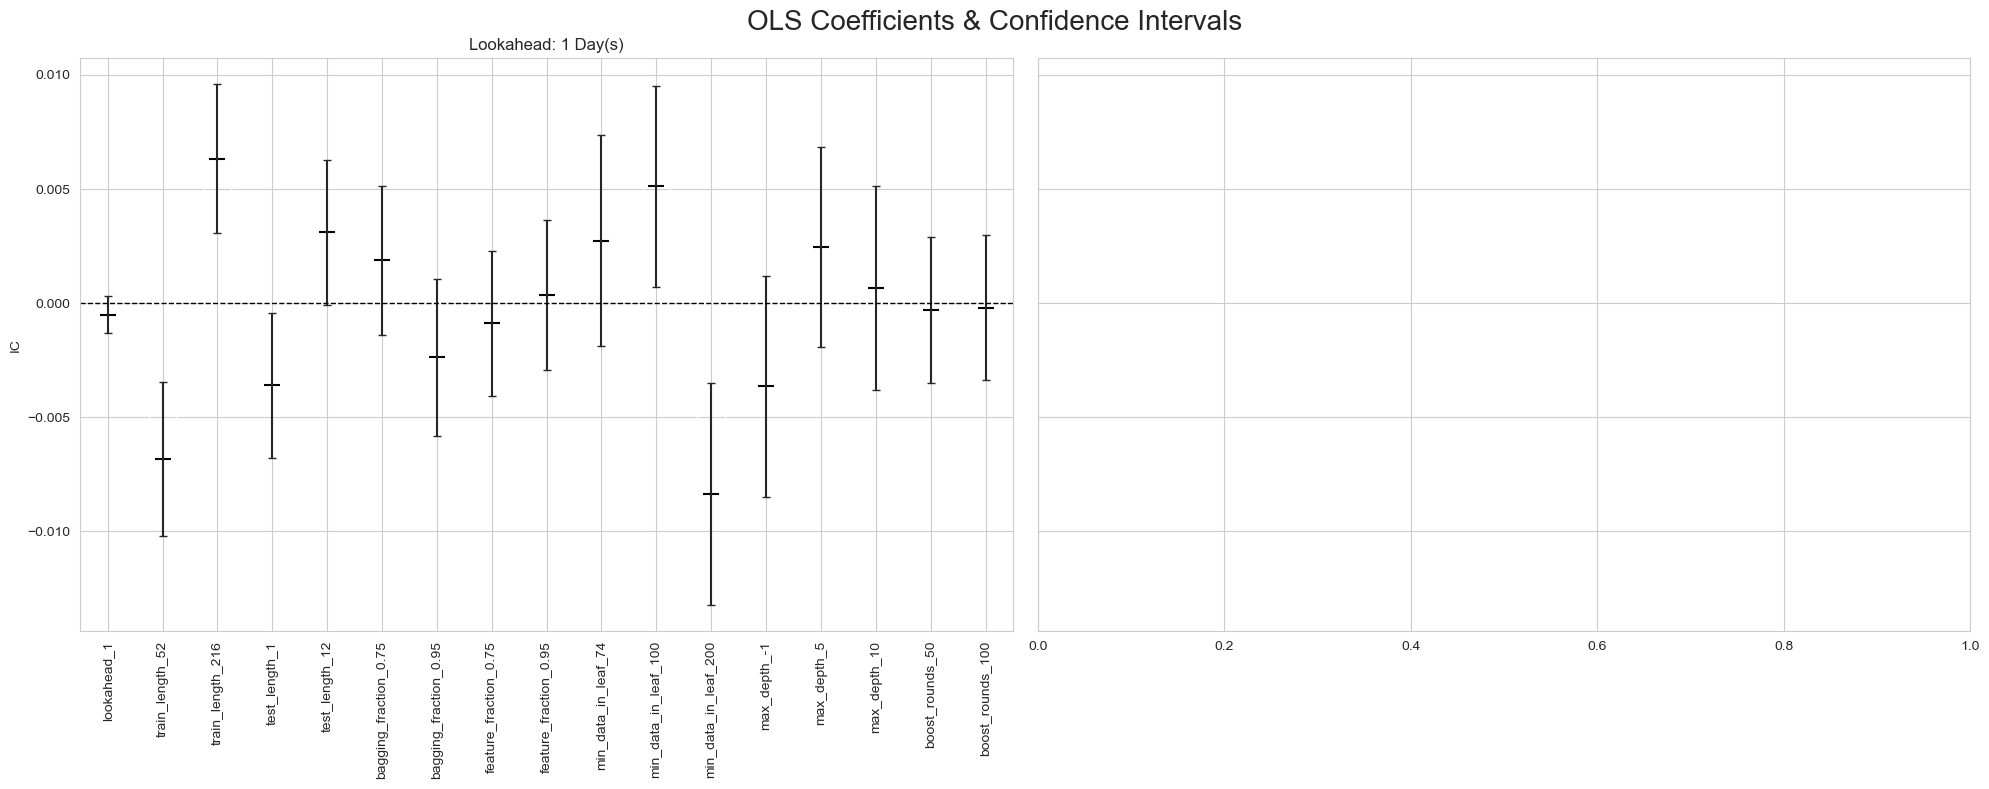

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8), sharey=True)
axes = axes.flatten()
#for i, t in enumerate([1, 2]):#modificado
for i, t in enumerate([1]):#modificado
    visualize_lr_result(lin_reg[t], axes[i])
    axes[i].set_title(f'Lookahead: {t} Day(s)')
fig.suptitle('OLS Coefficients & Confidence Intervals', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.92);

## Cross-validation Result: Best Hyperparameters

### LightGBM

The top-performing LightGBM models use the following parameters for the three different prediction horizons.

In [42]:
group_cols = scope_params + lgb_train_params + ['boost_rounds']
lgb_daily_ic.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(10, 'ic'))

lookahead  train_length  test_length  learning_rate  num_leaves  \
379          1           216           12            0.1           8   
414          1           216           12            0.3           8   
265          1           216            1            0.1           8   
413          1           216           12            0.3           4   
302          1           216            1            0.3           8   
387          1           216           12            0.1          32   
393          1           216           12            0.1         128   
382          1           216           12            0.1           8   
275          1           216            1            0.1          32   
283          1           216            1            0.1         128   

     feature_fraction  min_data_in_leaf  boost_rounds        ic  
379              0.30                50           100  0.056650  
414              0.30                50            50  0.054766  
265              0.95               100           100  0.052923  
413              0.95               200           100  0.052797  
302              0.95                50            50  0.052232  
387              0.30               100           100  0.051107  
393              0.30               100           100  0.051107  
382              0.95                50            50  0.050913  
275              0.95               200           100  0.048689  
283              0.95               200           100  0.048689

In [43]:
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic')).to_csv('results/best_lgb_model.csv', index=False)

In [44]:
lgb_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(10, 'daily_ic_mean'))

lookahead  train_length  test_length  learning_rate  num_leaves  \
124          1           216           12            0.1         8.0   
340          1           216           12            0.1         8.0   
109          1           216           12            0.3         8.0   
325          1           216           12            0.3         8.0   
182          1           216            1            0.1         8.0   
398          1           216            1            0.1         8.0   
111          1           216           12            0.3         4.0   
327          1           216           12            0.3         4.0   
163          1           216            1            0.3         8.0   
379          1           216            1            0.3         8.0   

     feature_fraction  min_data_in_leaf  daily_ic_mean  daily_ic_mean_n  \
124              0.30              50.0       0.056650            100.0   
340              0.30              50.0       0.056650            100.0   
109              0.30              50.0       0.054766             50.0   
325              0.30              50.0       0.054766             50.0   
182              0.95             100.0       0.052923            100.0   
398              0.95             100.0       0.052923            100.0   
111              0.95             200.0       0.052797            100.0   
327              0.95             200.0       0.052797            100.0   
163              0.95              50.0       0.052232             50.0   
379              0.95              50.0       0.052232             50.0   

     daily_ic_median  daily_ic_median_n  boost_rounds        ic  
124         0.063636              100.0            50  0.079586  
340         0.063636              100.0           100  0.076122  
109         0.072727               50.0            50  0.050509  
325         0.072727               50.0           100  0.040008  
182         0.081818              100.0            50  0.055574  
398         0.081818              100.0           100  0.049008  
111         0.036364              100.0            50  0.054255  
327         0.036364              100.0           100  0.065350  
163         0.036364               50.0            50  0.043074  
379         0.036364               50.0           100  0.045807

### Random Forest

The top-performing RF models use the following parameters for the three different prediction horizons.

In [45]:
group_cols = scope_params + rf_train_params + ['boost_rounds']
rf_daily_ic.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(10, 'ic'))

lookahead  train_length  test_length  bagging_fraction  feature_fraction  \
76           1           216            1              0.75              0.75   
134          1           216           12              0.95              0.75   
124          1           216           12              0.75              0.95   
110          1           216           12              0.75              0.75   
95           1           216            1              0.95              0.75   
126          1           216           12              0.75              0.95   
130          1           216           12              0.75              0.95   
122          1           216           12              0.75              0.95   
114          1           216           12              0.75              0.75   
118          1           216           12              0.75              0.75   

     min_data_in_leaf  max_depth  boost_rounds        ic  
76                100          5            50  0.036676  
134               100          5            50  0.035635  
124               100          5            50  0.027294  
110               100         -1            50  0.026129  
95                 74         10           100  0.024542  
126               100         10            50  0.023974  
130               200         10            50  0.023809  
122               100         -1            50  0.023757  
114               200         -1            50  0.023283  
118               200         10            50  0.023283

In [46]:
rf_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic'))
rf_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(3, 'ic')).to_csv('results/best_rf_model.csv', index=False)

In [47]:
rf_metrics.groupby('lookahead', group_keys=False).apply(lambda x: x.nlargest(10, 'daily_ic_mean'))

lookahead  train_length  test_length  bagging_fraction  feature_fraction  \
71           1           216            1              0.75              0.75   
143          1           216            1              0.75              0.75   
41           1           216           12              0.95              0.75   
113          1           216           12              0.95              0.75   
47           1           216           12              0.75              0.95   
119          1           216           12              0.75              0.95   
52           1           216           12              0.75              0.75   
124          1           216           12              0.75              0.75   
58           1           216            1              0.95              0.75   
130          1           216            1              0.95              0.75   

     min_data_in_leaf  max_depth  daily_ic_mean  daily_ic_mean_n  \
71              100.0        5.0       0.036676             50.0   
143             100.0        5.0       0.036676             50.0   
41              100.0        5.0       0.035635             50.0   
113             100.0        5.0       0.035635             50.0   
47              100.0        5.0       0.027294             50.0   
119             100.0        5.0       0.027294             50.0   
52              100.0       -1.0       0.026129             50.0   
124             100.0       -1.0       0.026129             50.0   
58               74.0       10.0       0.024542            100.0   
130              74.0       10.0       0.024542            100.0   

     daily_ic_median  daily_ic_median_n  boost_rounds        ic  
71          0.022831               50.0            50 -0.015890  
143         0.022831               50.0           100 -0.011994  
41          0.064613               50.0            50  0.041760  
113         0.064613               50.0           100  0.043838  
47          0.032186              100.0            50  0.027903  
119         0.032186              100.0           100  0.031695  
52          0.000000              100.0            50  0.037718  
124         0.000000              100.0           100  0.045034  
58          0.027273              100.0            50  0.025969  
130         0.027273              100.0           100  0.032129

sns.jointplot(x=lgb_metrics.daily_ic_mean,y=lgb_metrics.ic);

### Visualization

#### LightGBM

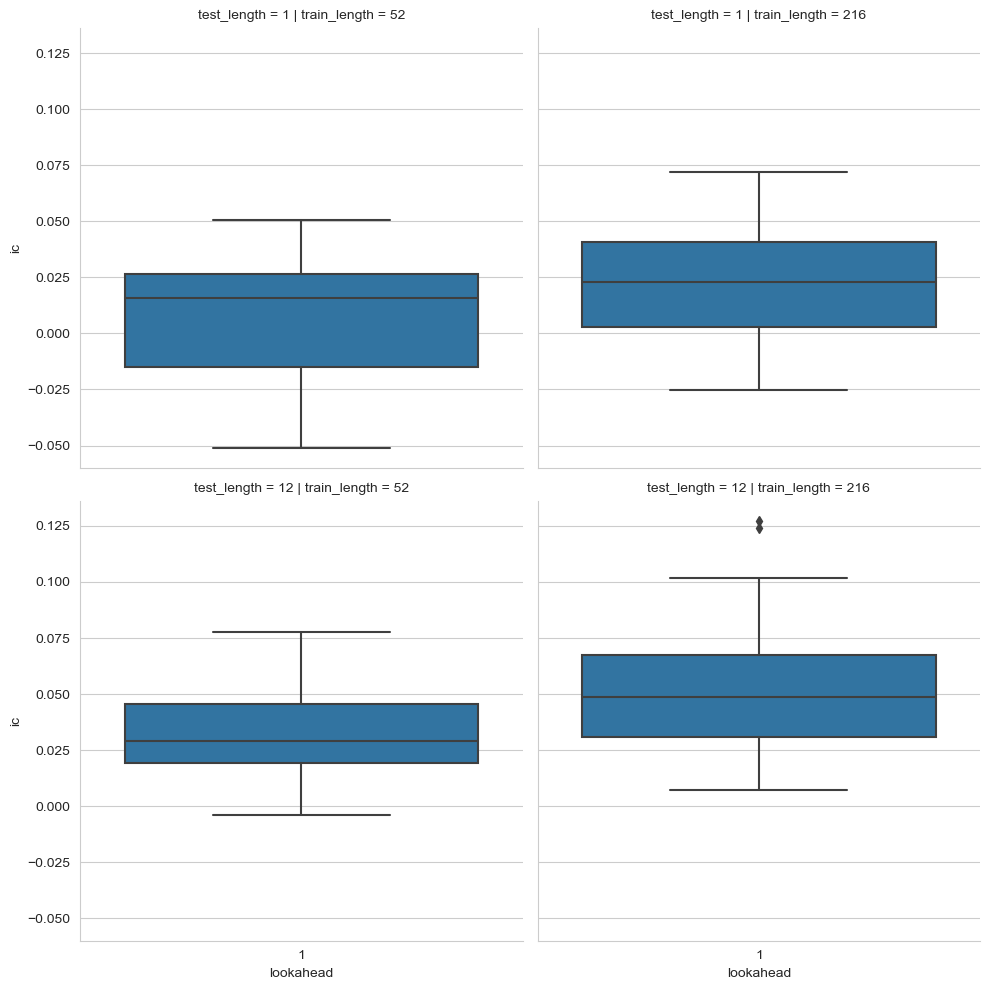

In [48]:
g = sns.catplot(x='lookahead', y='ic',
                col='train_length', row='test_length',
                data=lgb_metrics,
                kind='box')

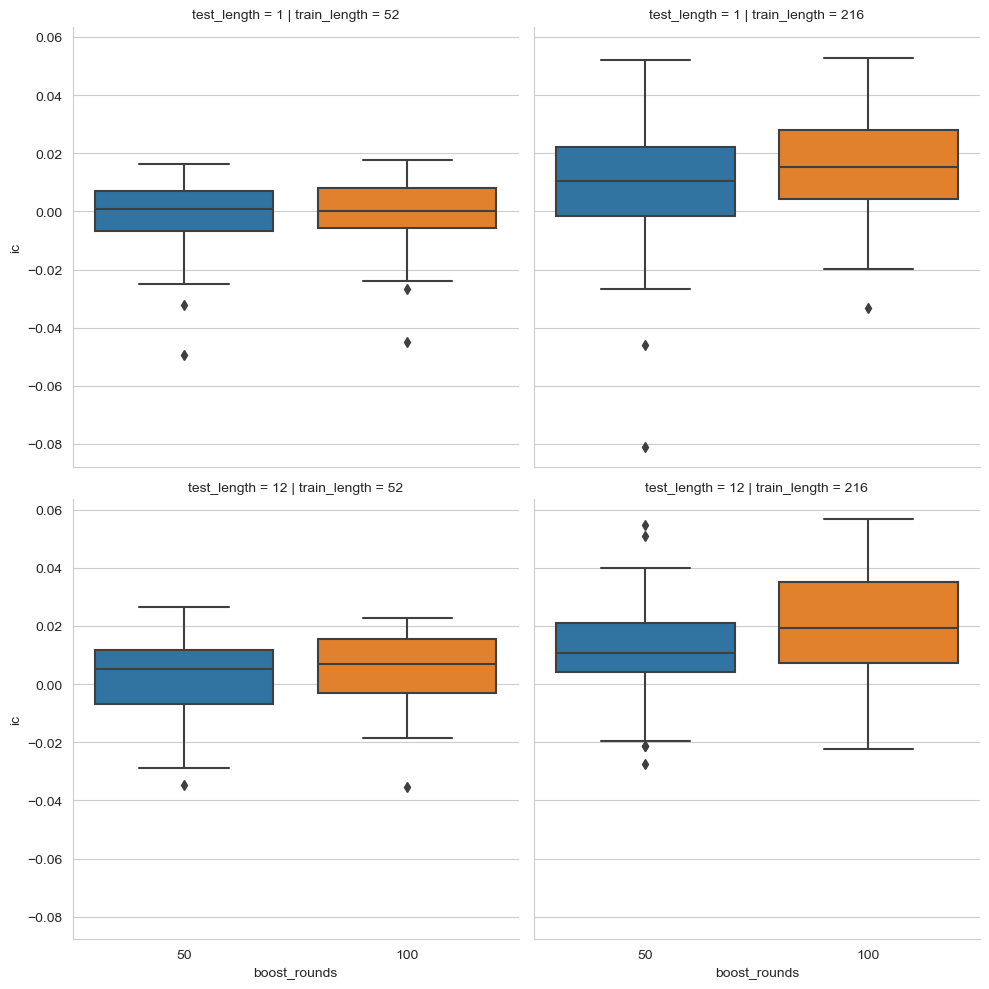

In [49]:
t=1
g=sns.catplot(x='boost_rounds',
            y='ic',
            col='train_length',
            row='test_length',
            data=lgb_daily_ic[lgb_daily_ic.lookahead == t],
            kind='box')

### Random forest

#### Random Forest

Some figures are empty because we did not run those parameter combinations.

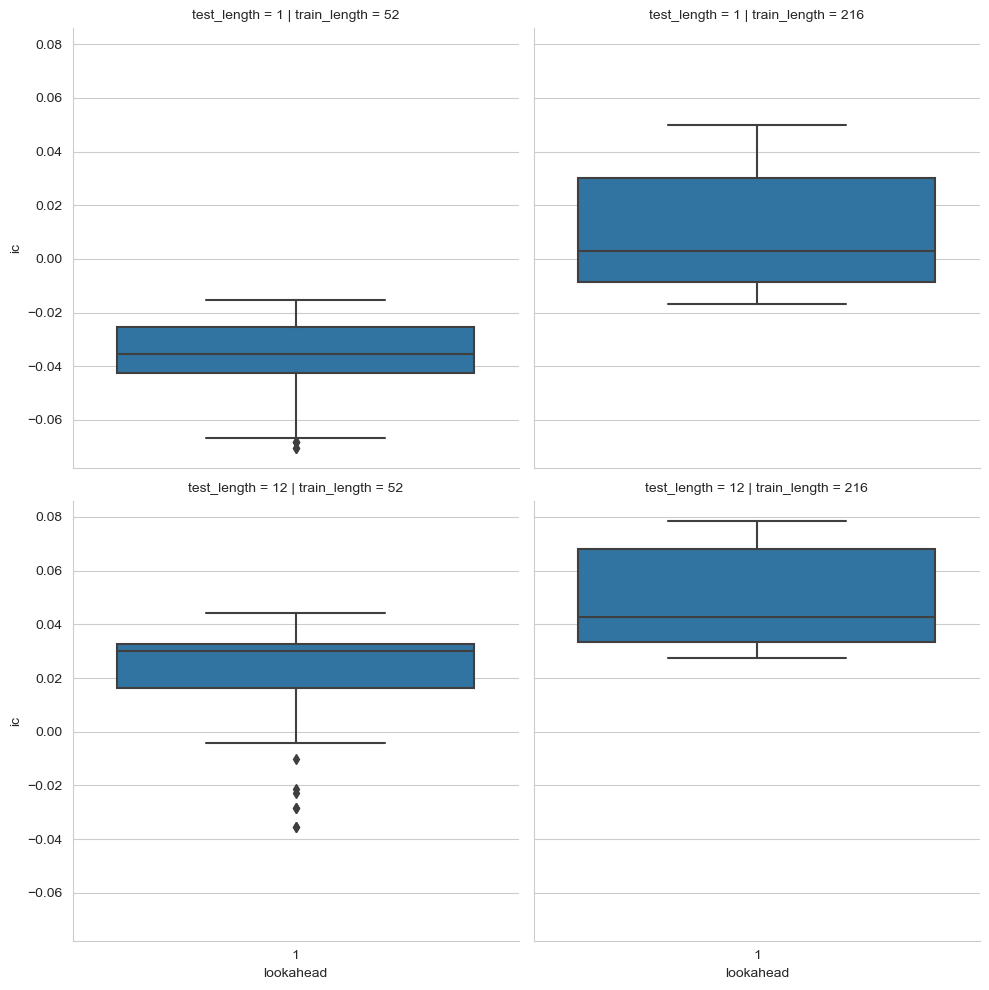

In [50]:
g = sns.catplot(x='lookahead', y='ic',
                col='train_length', row='test_length',
                data=rf_metrics,
                kind='box')

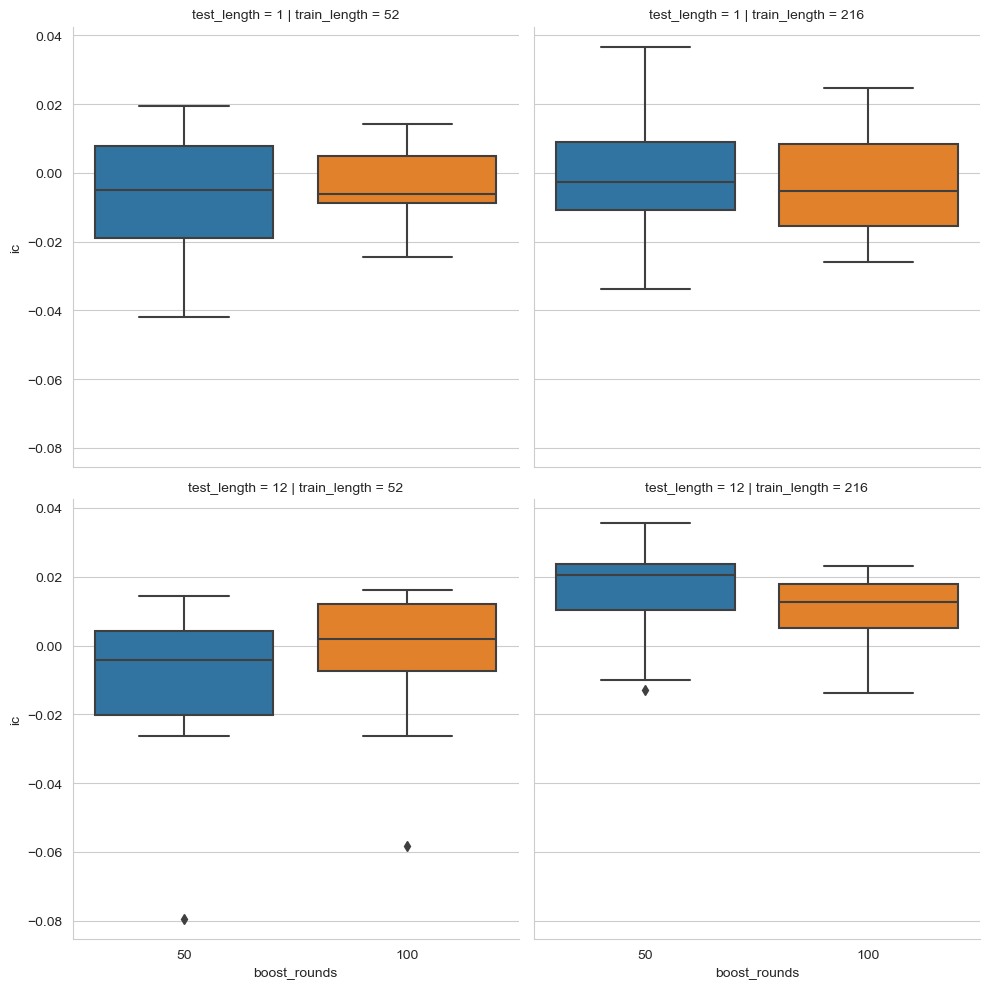

In [51]:
t=1
g=sns.catplot(x='boost_rounds',
            y='ic',
            col='train_length',
            row='test_length',
            data=rf_daily_ic[rf_daily_ic.lookahead == t],
            kind='box')

The top-performing LightGBM models use the following parameters for the three different prediction horizons.

## AlphaLens Analysis - Validation Performance

### LightGBM

#### Select Parameters

In [52]:
lgb_daily_ic = pd.read_hdf('data/model_tuning.h5', 'lgb/daily_ic')
lgb_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3508 entries, 0 to 3507
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         3508 non-null   int64  
 1   train_length      3508 non-null   int64  
 2   test_length       3508 non-null   int64  
 3   learning_rate     3508 non-null   float64
 4   num_leaves        3508 non-null   int64  
 5   feature_fraction  3508 non-null   float64
 6   min_data_in_leaf  3508 non-null   int64  
 7   boost_rounds      3508 non-null   int64  
 8   ic                3508 non-null   float64
dtypes: float64(3), int64(6)
memory usage: 274.1 KB


In [53]:
def get_lgb_params(data, t=5, best=0):
    param_cols = scope_params[1:] + lgb_train_params + ['boost_rounds']
    df = data[data.lookahead==t].sort_values('ic', ascending=False).iloc[best]
    return df.loc[param_cols]

In [54]:
def get_lgb_key(t, p):
    key = f'{t}/{int(p.train_length)}/{int(p.test_length)}/{p.learning_rate}/'
    return key + f'{int(p.num_leaves)}/{p.feature_fraction}/{int(p.min_data_in_leaf)}'

In [55]:
best_params = get_lgb_params(lgb_daily_ic, t=1, best=0)
best_params

train_length         520.0
test_length            1.0
learning_rate          0.3
num_leaves           128.0
feature_fraction       0.3
min_data_in_leaf    1000.0
boost_rounds         250.0
Name: 683, dtype: float64

In [57]:
best_params.to_hdf('data/data.h5', 'best_params')

#### Plot rolling IC

In [57]:
def select_ic(params, ic_data, lookahead):
    return ic_data.loc[(ic_data.lookahead == lookahead) &
                       (ic_data.train_length == params.train_length) &
                       (ic_data.test_length == params.test_length) &
                       (ic_data.learning_rate == params.learning_rate) &
                       (ic_data.num_leaves == params.num_leaves) &
                       (ic_data.feature_fraction == params.feature_fraction) &
                       (ic_data.boost_rounds == params.boost_rounds), ['date', 'ic']].set_index('date')

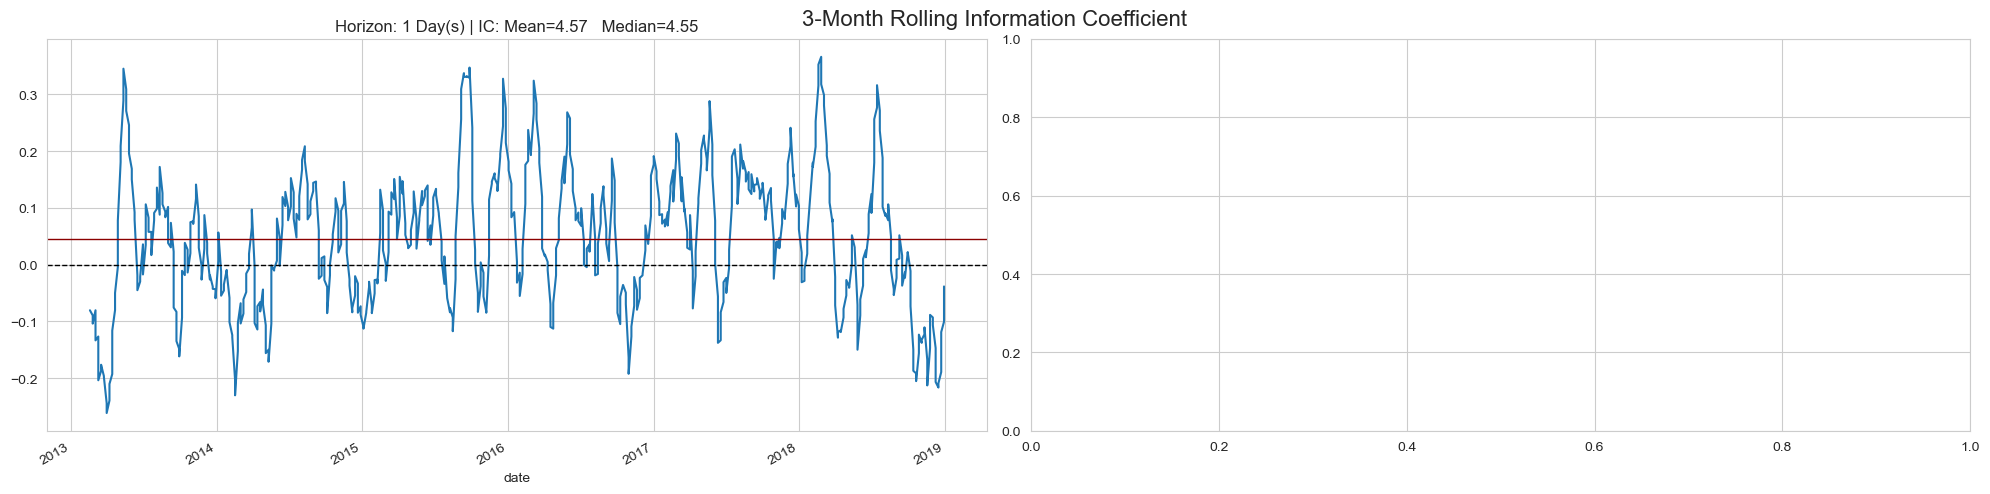

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes = axes.flatten()


for i, t in enumerate([1]): #modificado para meses un lookahead
    params = get_lgb_params(lgb_daily_ic, t=t)
    data = select_ic(params, lgb_ic, lookahead=t).sort_index()
    #rolling = data.rolling(63).ic.mean().dropna()
    rolling = data.rolling(3*4).ic.mean().dropna()#semanas
    avg = data.ic.mean()
    med = data.ic.median()
    rolling.plot(ax=axes[i], title=f'Horizon: {t} Day(s) | IC: Mean={avg*100:.2f}   Median={med*100:.2f}')
    axes[i].axhline(avg, c='darkred', lw=1)
    axes[i].axhline(0, ls='--', c='k', lw=1)

fig.suptitle('3-Month Rolling Information Coefficient', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.92);

In [59]:
t

1

#### Get Predictions for Validation Period

We retrieve the predictions for the 10 validation runs:

In [60]:
lookahead = 1
topn = 10
for best in range(topn):
    best_params = get_lgb_params(lgb_daily_ic, t=lookahead, best=best)
    key = get_lgb_key(lookahead, best_params)
    rounds = str(int(best_params.boost_rounds))
    if best == 0:
        best_predictions = pd.read_hdf(results_path / 'tuning_lgb.h5', 'predictions/' + key)
        best_predictions = best_predictions[rounds].to_frame(best)
    else:
        best_predictions[best] = pd.read_hdf(results_path / 'tuning_lgb.h5',
                                             'predictions/' + key)[rounds]
best_predictions = best_predictions.sort_index()

In [61]:
best_predictions.to_hdf('data/predictions.h5', f'lgb/train/{lookahead:02}')
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3432 entries, ('IYR', Timestamp('2013-01-13 00:00:00')) to ('XLY', Timestamp('2018-12-30 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       3432 non-null   float64
 1   1       3432 non-null   float64
 2   2       3432 non-null   float64
 3   3       3432 non-null   float64
 4   4       3432 non-null   float64
 5   5       3432 non-null   float64
 6   6       3432 non-null   float64
 7   7       3432 non-null   float64
 8   8       3432 non-null   float64
 9   9       3432 non-null   float64
dtypes: float64(10)
memory usage: 289.2+ KB


#### Get Trade Prices

Using next available prices. !! Esta parte del código no está revisada para una adaptacion mensual, no tomar como buena para conclusiones

In [62]:
#modificado
def get_trade_prices(tickers):
    idx = pd.IndexSlice
    DATA_STORE = '../data/assets.h5'
    with pd.HDFStore(DATA_STORE) as store:
        prices = (store['data_close'])  
    
    return (prices.loc[idx[tickers, '2012': '2024'], 'open']
            .unstack('ticker')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC')
            .resample('W').last())

In [64]:
test_tickers = best_predictions.index.get_level_values('ticker').unique()#modificado

In [65]:
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 665 entries, 2012-01-08 00:00:00+00:00 to 2024-09-29 00:00:00+00:00
Freq: W-SUN
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IYR     664 non-null    float64
 1   VOX     664 non-null    float64
 2   XLB     664 non-null    float64
 3   XLE     664 non-null    float64
 4   XLF     664 non-null    float64
 5   XLI     664 non-null    float64
 6   XLK     664 non-null    float64
 7   XLP     664 non-null    float64
 8   XLU     664 non-null    float64
 9   XLV     664 non-null    float64
 10  XLY     664 non-null    float64
dtypes: float64(11)
memory usage: 62.3 KB


In [66]:
# persist result in case we want to rerun:
trade_prices.to_hdf('data/model_tuning.h5', 'trade_prices/model_selection')
trade_prices = pd.read_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

In [67]:
trade_prices.tail()

ticker                            IYR         VOX        XLB        XLE  \
date                                                                      
2024-09-01 00:00:00+00:00   98.800003  138.529999  92.910004  89.790001   
2024-09-08 00:00:00+00:00   99.349998  134.729996  90.410004  86.269997   
2024-09-15 00:00:00+00:00  103.599998  139.139999  93.099998  86.309998   
2024-09-22 00:00:00+00:00  102.769997  143.990005  94.019997  88.199997   
2024-09-29 00:00:00+00:00         NaN         NaN        NaN        NaN   

ticker                           XLF         XLI         XLK        XLP  \
date                                                                      
2024-09-01 00:00:00+00:00  45.500000  130.809998  218.000000  82.529999   
2024-09-08 00:00:00+00:00  44.709999  126.959999  206.449997  83.000000   
2024-09-15 00:00:00+00:00  44.700001  131.139999  218.850006  84.150002   
2024-09-22 00:00:00+00:00  45.490002  133.259995  222.330002  82.440002   
2024-09-29 00:00:00+00:00        NaN         NaN         NaN        NaN   

ticker                           XLU         XLV         XLY  
date                                                          
2024-09-01 00:00:00+00:00  76.309998  156.880005  186.580002  
2024-09-08 00:00:00+00:00  76.239998  154.339996  184.309998  
2024-09-15 00:00:00+00:00  78.790001  156.979996  192.380005  
2024-09-22 00:00:00+00:00  80.029999  155.190002  197.110001  
2024-09-29 00:00:00+00:00        NaN         NaN         NaN

We average the top five models and provide the corresponding prices to Alphalens, in order to compute the mean period-wise return earned on an equal-weighted portfolio invested in the daily factor quintiles for various holding periods:

In [68]:
factor = best_predictions.iloc[:, :5].mean(1).dropna().tz_localize('UTC', level='date').swaplevel()

In [69]:
factor.tail()

date                       ticker
2018-12-02 00:00:00+00:00  XLY       0.033325
2018-12-09 00:00:00+00:00  XLY       0.860946
2018-12-16 00:00:00+00:00  XLY      -0.060708
2018-12-23 00:00:00+00:00  XLY       0.500840
2018-12-30 00:00:00+00:00  XLY      -0.611687
dtype: float64

In [70]:
#trade_prices= trade_prices.asfreq('W')

In [71]:
trade_prices.tail()

ticker                            IYR         VOX        XLB        XLE  \
date                                                                      
2024-09-01 00:00:00+00:00   98.800003  138.529999  92.910004  89.790001   
2024-09-08 00:00:00+00:00   99.349998  134.729996  90.410004  86.269997   
2024-09-15 00:00:00+00:00  103.599998  139.139999  93.099998  86.309998   
2024-09-22 00:00:00+00:00  102.769997  143.990005  94.019997  88.199997   
2024-09-29 00:00:00+00:00         NaN         NaN        NaN        NaN   

ticker                           XLF         XLI         XLK        XLP  \
date                                                                      
2024-09-01 00:00:00+00:00  45.500000  130.809998  218.000000  82.529999   
2024-09-08 00:00:00+00:00  44.709999  126.959999  206.449997  83.000000   
2024-09-15 00:00:00+00:00  44.700001  131.139999  218.850006  84.150002   
2024-09-22 00:00:00+00:00  45.490002  133.259995  222.330002  82.440002   
2024-09-29 00:00:00+00:00        NaN         NaN         NaN        NaN   

ticker                           XLU         XLV         XLY  
date                                                          
2024-09-01 00:00:00+00:00  76.309998  156.880005  186.580002  
2024-09-08 00:00:00+00:00  76.239998  154.339996  184.309998  
2024-09-15 00:00:00+00:00  78.790001  156.979996  192.380005  
2024-09-22 00:00:00+00:00  80.029999  155.190002  197.110001  
2024-09-29 00:00:00+00:00        NaN         NaN         NaN

In [72]:
freq = pd.infer_freq(trade_prices.index)
print(freq)

W-SUN


#### Create AlphaLens Inputs

In [73]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   #periods=(1, 2))#modificado
                                                   periods=(1,2),max_loss=2)#modificado

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 200.0%, not exceeded: OK!


#### Compute Alphalens metrics

In [74]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

In [75]:
factor_returns = perf.factor_returns(factor_data)

In [76]:
mean_quant_ret, std_quantile = perf.mean_return_by_quantile(factor_data,
                                                            by_group=False,
                                                            demeaned=True)



mean_quant_rateret = mean_quant_ret.apply(rate_of_return, axis=0,
                                          base_period=mean_quant_ret.columns[0])

In [77]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

mean_quant_rateret_bydate = mean_quant_ret_bydate.apply(
    rate_of_return,
    base_period=mean_quant_ret_bydate.columns[0],
)

compstd_quant_daily = std_quant_daily.apply(std_conversion,
                                            base_period=std_quant_daily.columns[0])

alpha_beta = perf.factor_alpha_beta(factor_data,
                                    demeaned=True)

mean_ret_spread_quant, std_spread_quant = perf.compute_mean_returns_spread(
    mean_quant_rateret_bydate,
    factor_data["factor_quantile"].max(),
    factor_data["factor_quantile"].min(),
    std_err=compstd_quant_daily,
)

In [78]:
mean_ret_spread_quant.mean().mul(10000).to_frame('Mean Period Wise Spread (bps)').join(alpha_beta.T).T

1D        2D
Mean Period Wise Spread (bps)  14.948396  7.279377
Ann. alpha                      0.211800  0.093044
beta                            0.045969  0.054071

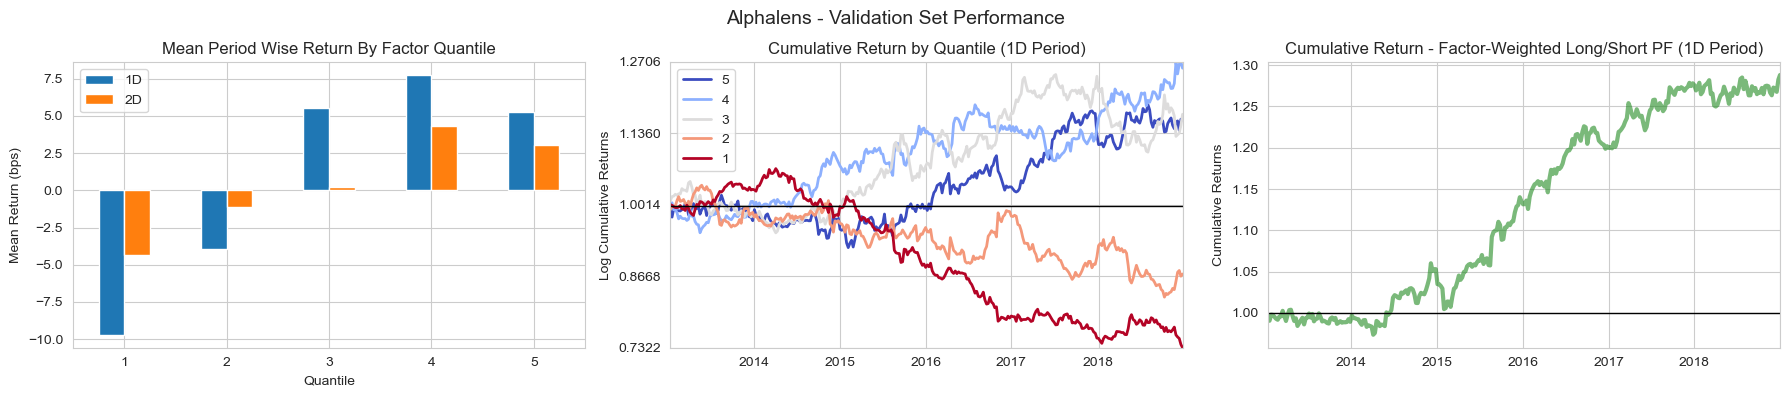

In [79]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 4))


plotting.plot_quantile_returns_bar(mean_quant_rateret, ax=axes[0])
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=0)
axes[0].set_xlabel('Quantile')

plotting.plot_cumulative_returns_by_quantile(mean_quant_ret_bydate['1D'],
                                             freq=pd.tseries.offsets.BDay(),
                                             period='1D',
                                             ax=axes[1])
axes[1].set_title('Cumulative Return by Quantile (1D Period)')

title = "Cumulative Return - Factor-Weighted Long/Short PF (1D Period)"
plotting.plot_cumulative_returns(factor_returns['1D'],
                                 period='1D',
                                 freq=pd.tseries.offsets.BDay(),
                                 title=title,
                                 ax=axes[2])

fig.suptitle('Alphalens - Validation Set Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

#### Summary Tearsheet

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.906265  1.132400 -0.056174  0.360050    936  27.272727
2               -0.777735  1.215506  0.031127  0.356612    624  18.181818
3               -0.727762  1.248175  0.083476  0.358598    624  18.181818
4               -0.626876  1.280870  0.134450  0.360361    624  18.181818
5               -0.552595  1.430568  0.211041  0.368907    624  18.181818

Returns Analysis


1D     2D
Ann. alpha                                      0.212  0.093
beta                                            0.046  0.054
Mean Period Wise Return Top Quantile (bps)      5.244  3.062
Mean Period Wise Return Bottom Quantile (bps)  -9.704 -4.344
Mean Period Wise Spread (bps)                  14.948  7.279

Information Analysis


1D     2D
IC Mean           0.047  0.035
IC Std.           0.350  0.351
Risk-Adjusted IC  0.133  0.100
t-stat(IC)        2.350  1.773
p-value(IC)       0.019  0.077
IC Skew          -0.106 -0.119
IC Kurtosis      -0.676 -0.493

Turnover Analysis


1D     2D
Quantile 1 Mean Turnover   0.646  0.648
Quantile 2 Mean Turnover   0.818  0.802
Quantile 3 Mean Turnover   0.805  0.818
Quantile 4 Mean Turnover   0.805  0.792
Quantile 5 Mean Turnover   0.688  0.710

1D     2D
Mean Factor Rank Autocorrelation  0.211  0.178

<Figure size 640x480 with 0 Axes>

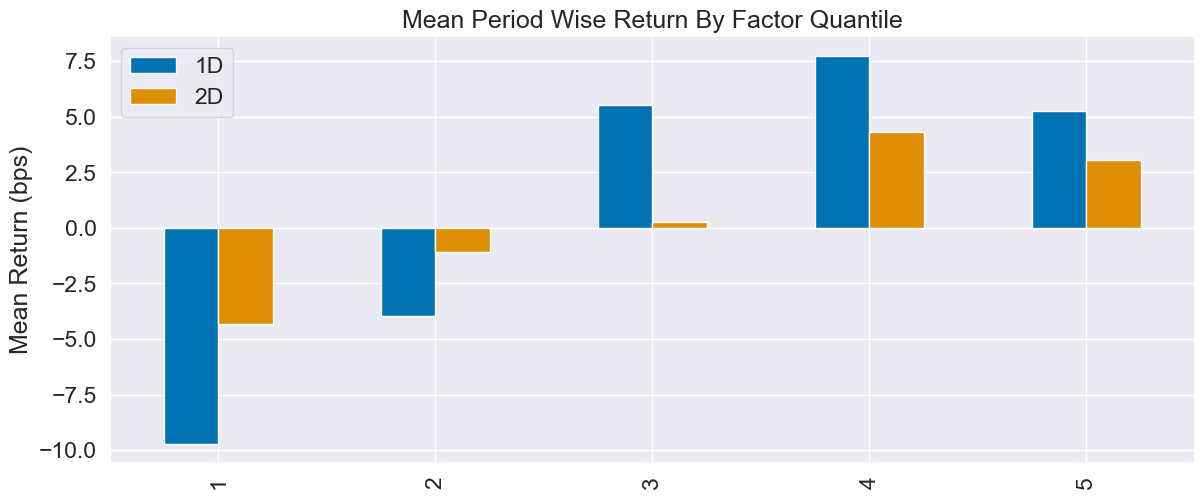

In [80]:
create_summary_tear_sheet(factor_data)

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.906265  1.132400 -0.056174  0.360050    936  27.272727
2               -0.777735  1.215506  0.031127  0.356612    624  18.181818
3               -0.727762  1.248175  0.083476  0.358598    624  18.181818
4               -0.626876  1.280870  0.134450  0.360361    624  18.181818
5               -0.552595  1.430568  0.211041  0.368907    624  18.181818

Returns Analysis


1D     2D
Ann. alpha                                      0.212  0.093
beta                                            0.046  0.054
Mean Period Wise Return Top Quantile (bps)      5.244  3.062
Mean Period Wise Return Bottom Quantile (bps)  -9.704 -4.344
Mean Period Wise Spread (bps)                  14.948  7.279

<Figure size 640x480 with 0 Axes>

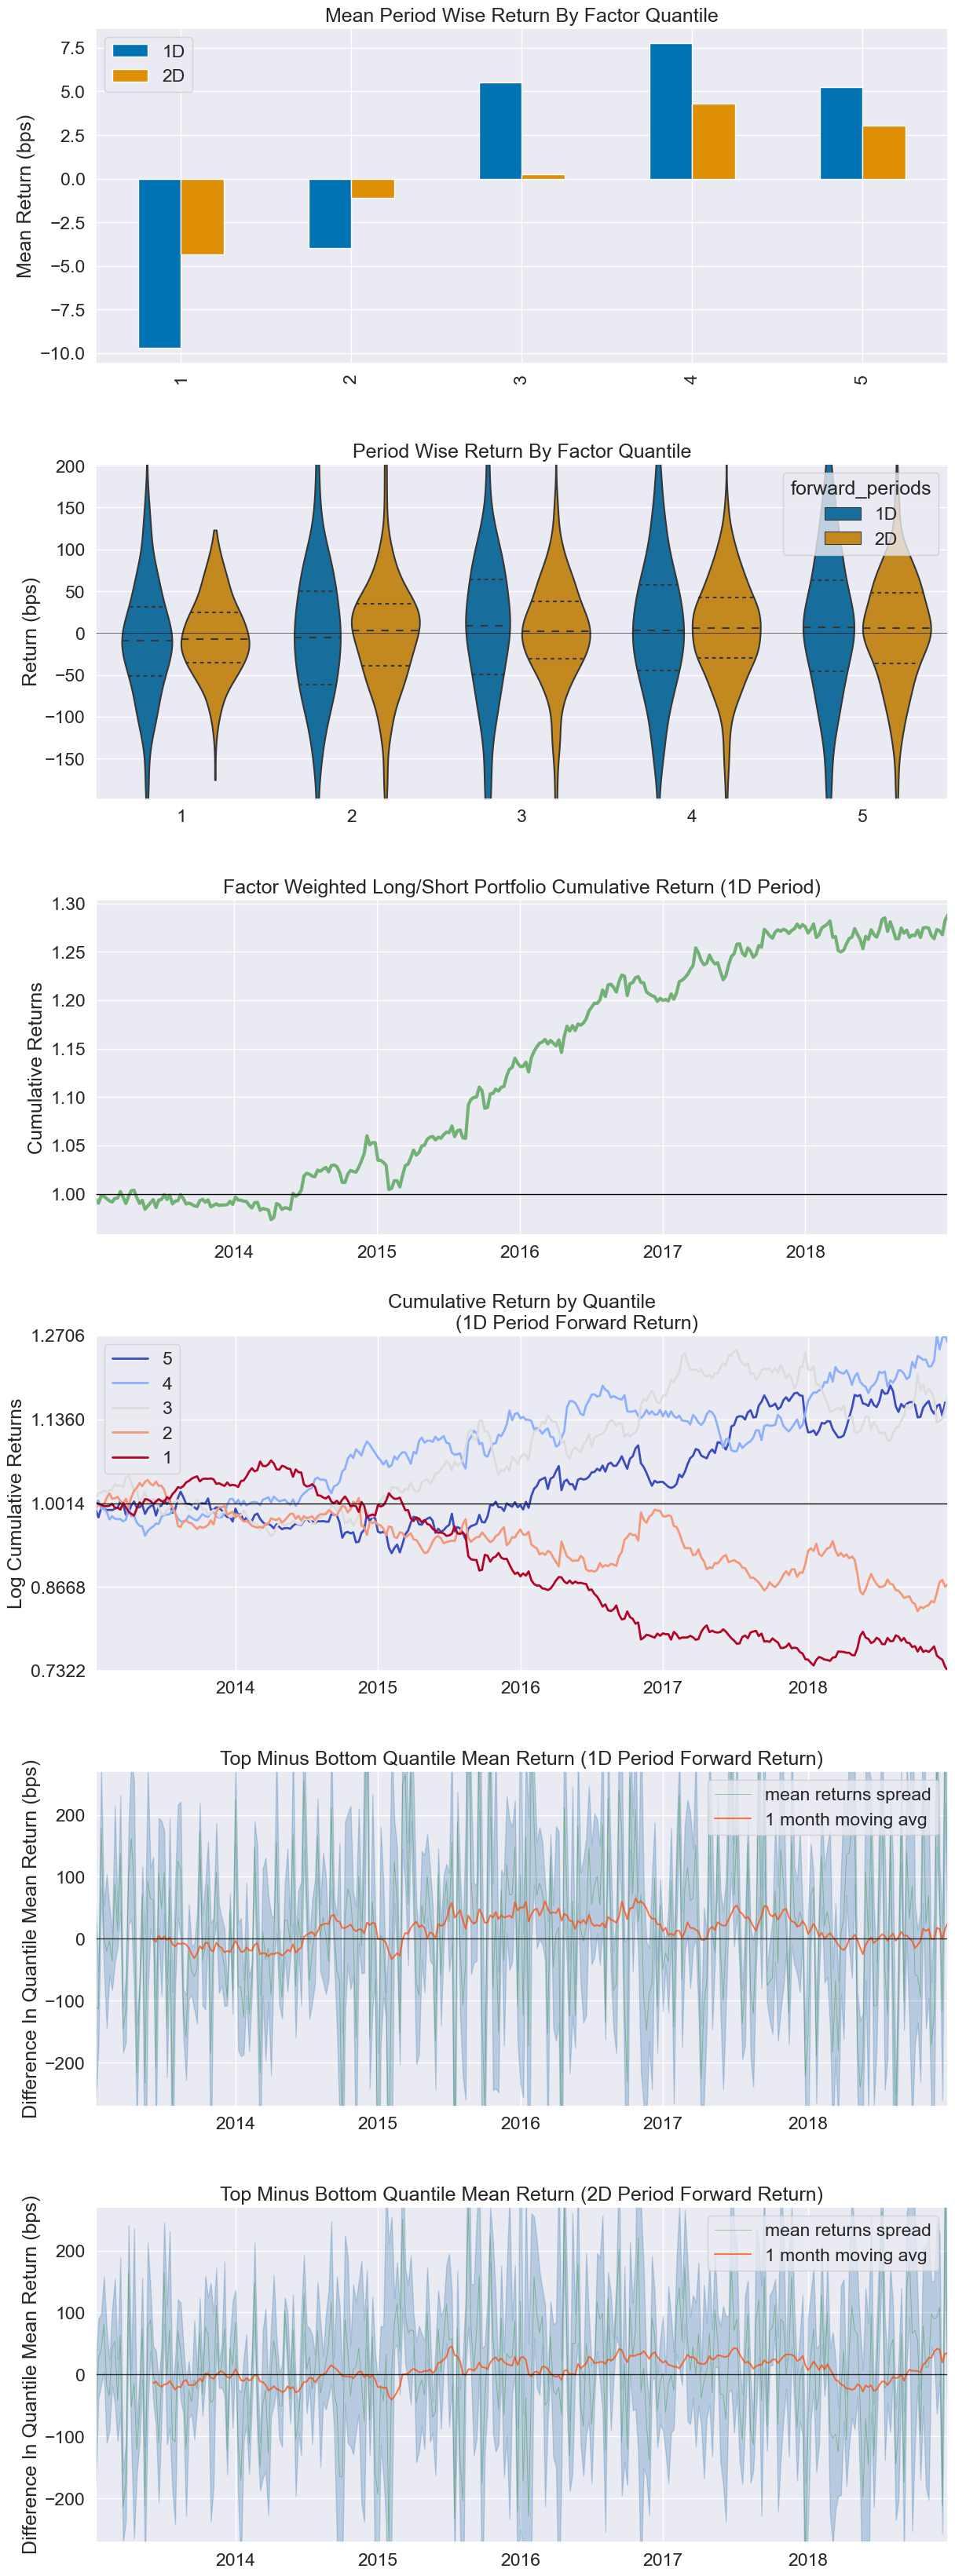

Information Analysis


1D     2D
IC Mean           0.047  0.035
IC Std.           0.350  0.351
Risk-Adjusted IC  0.133  0.100
t-stat(IC)        2.350  1.773
p-value(IC)       0.019  0.077
IC Skew          -0.106 -0.119
IC Kurtosis      -0.676 -0.493

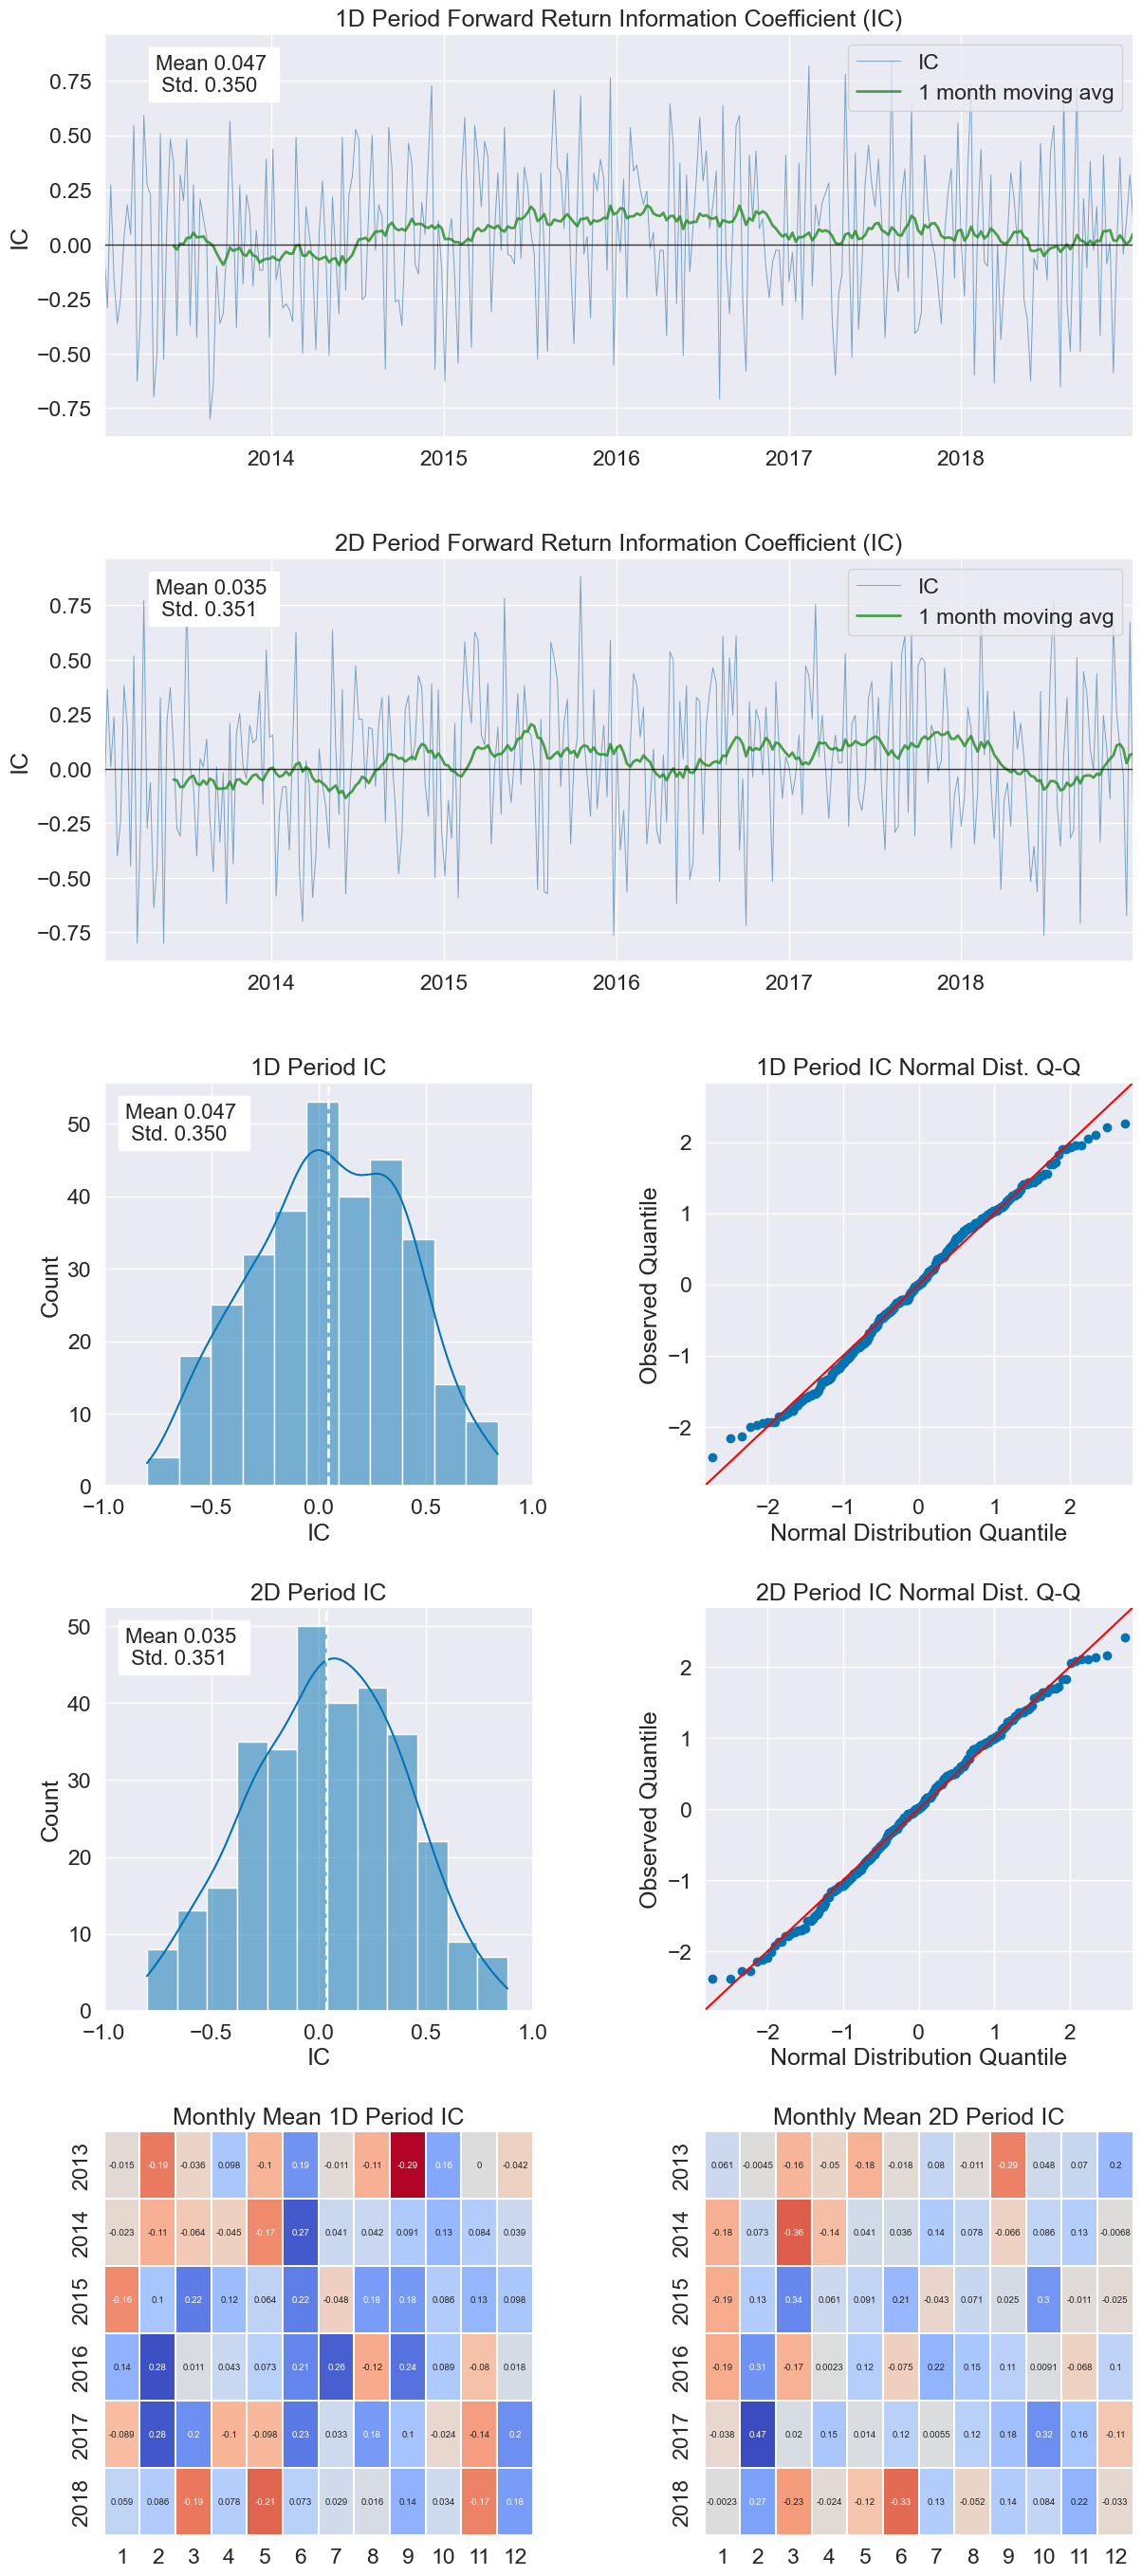

Turnover Analysis


1D     2D
Quantile 1 Mean Turnover   0.646  0.648
Quantile 2 Mean Turnover   0.818  0.802
Quantile 3 Mean Turnover   0.805  0.818
Quantile 4 Mean Turnover   0.805  0.792
Quantile 5 Mean Turnover   0.688  0.710

1D     2D
Mean Factor Rank Autocorrelation  0.211  0.178

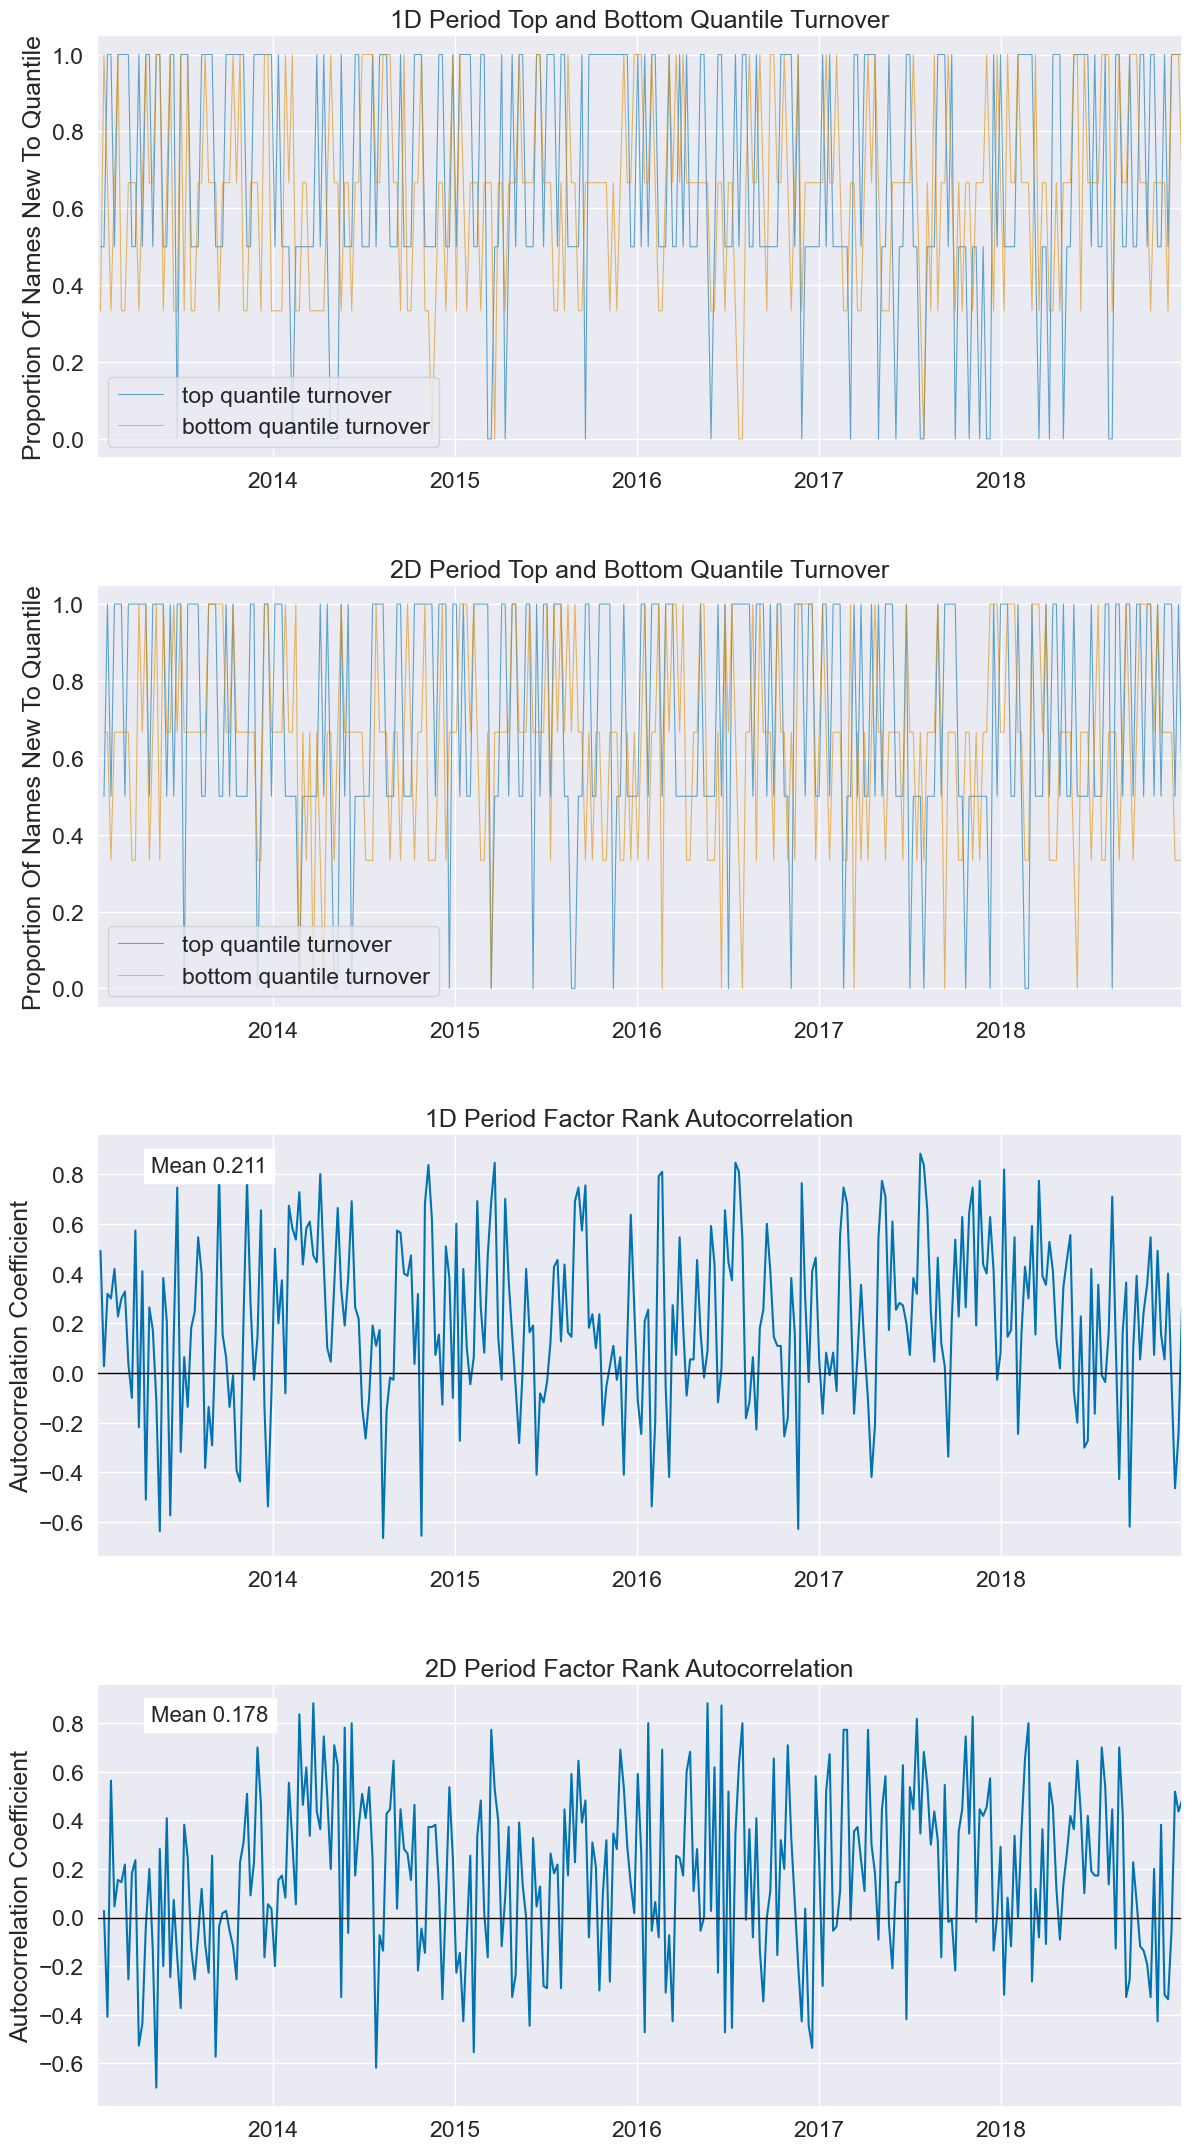

In [81]:
create_full_tear_sheet(factor_data)

### Random Forest

#### Select Parameters

In [82]:
rf_daily_ic = pd.read_hdf('data/model_tuning.h5', 'rf/daily_ic')
rf_daily_ic.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   lookahead         144 non-null    int64  
 1   train_length      144 non-null    int64  
 2   test_length       144 non-null    int64  
 3   bagging_fraction  144 non-null    float64
 4   feature_fraction  144 non-null    float64
 5   min_data_in_leaf  144 non-null    int64  
 6   max_depth         144 non-null    int64  
 7   boost_rounds      144 non-null    int64  
 8   ic                144 non-null    float64
dtypes: float64(3), int64(6)
memory usage: 11.2 KB


In [83]:
def get_rf_params(data, t=5, best=0):
    param_cols = scope_params[1:] + rf_train_params + ['boost_rounds']
    df = data[data.lookahead==t].sort_values('ic', ascending=False).iloc[best]
    return df.loc[param_cols]

In [84]:
def get_rf_key(t, p):
    key = f'{t}/{int(p.train_length)}/{int(p.test_length)}/{p.bagging_fraction}/'
    return key + f'{p.feature_fraction}/{int(p.min_data_in_leaf)}/{int(p.max_depth)}'

In [85]:
best_params_rf = get_rf_params(rf_daily_ic, t=1, best=0)
best_params_rf

train_length        216.00
test_length           1.00
bagging_fraction      0.75
feature_fraction      0.75
min_data_in_leaf    100.00
max_depth             5.00
boost_rounds         50.00
Name: 76, dtype: float64

In [86]:
best_params_rf.to_hdf('data.h5', 'best_params_rf')

#### Plot rolling IC

In [87]:
def select_ic(params, ic_data, lookahead):
    return ic_data.loc[(ic_data.lookahead == lookahead) &
                       (ic_data.train_length == params.train_length) &
                       (ic_data.test_length == params.test_length) &
                       (ic_data.bagging_fraction == params.bagging_fraction) &
                       (ic_data.feature_fraction == params.feature_fraction) &
                       (ic_data.max_depth == params.max_depth) &
                       (ic_data.boost_rounds == params.boost_rounds), ['date', 'ic']].set_index('date')

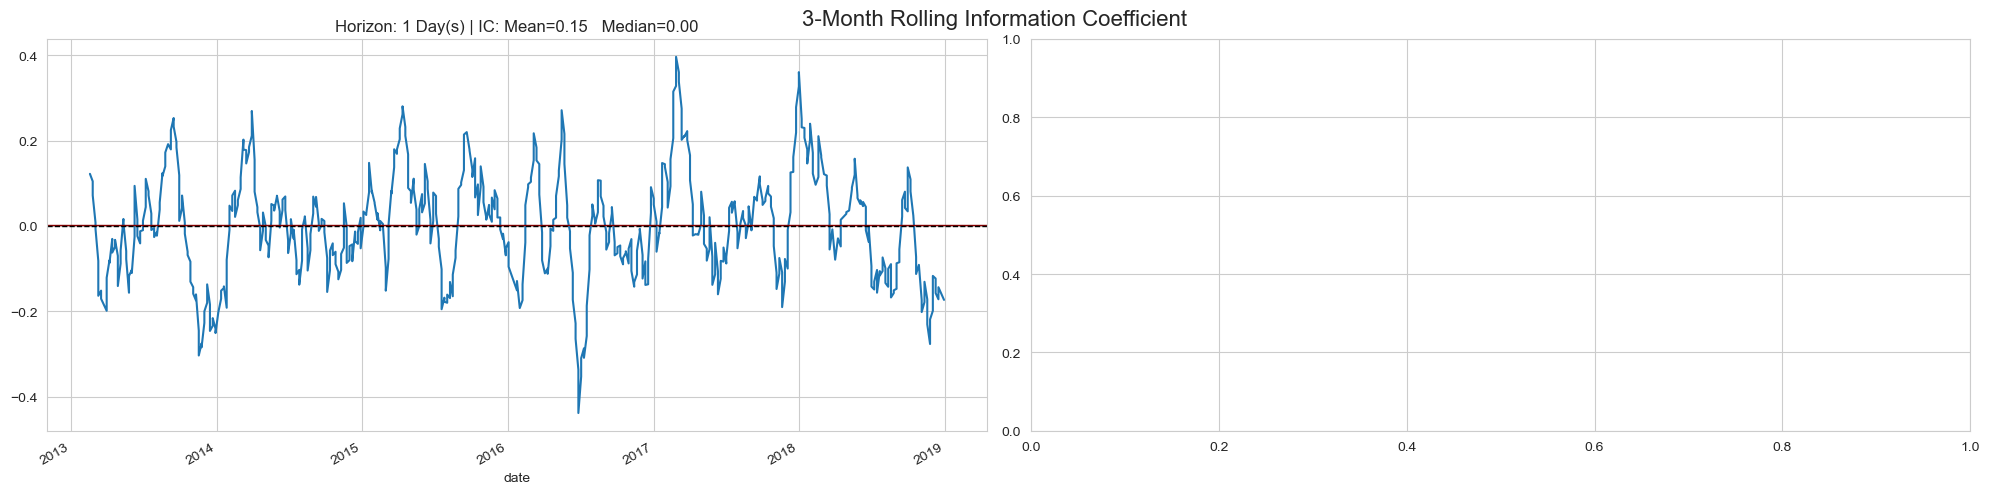

In [88]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes = axes.flatten()
for i, t in enumerate([1]):#modificado para meses
    params = get_rf_params(rf_daily_ic, t=t)
    data = select_ic(params, rf_ic, lookahead=t).sort_index()
    #rolling = data.rolling(63).ic.mean().dropna()
    rolling = data.rolling(3*4).ic.mean().dropna()#semanas
    avg = data.ic.mean()
    med = data.ic.median()
    rolling.plot(ax=axes[i], title=f'Horizon: {t} Day(s) | IC: Mean={avg*100:.2f}   Median={med*100:.2f}')
    axes[i].axhline(avg, c='darkred', lw=1)
    axes[i].axhline(0, ls='--', c='k', lw=1)

fig.suptitle('3-Month Rolling Information Coefficient', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.92);

#### Get Predictions for Validation Period

We retrieve the predictions for the 10 validation runs:

In [89]:
lookahead = 1
topn = 10
for best in range(topn):
    best_params = get_rf_params(rf_daily_ic, t=lookahead, best=best)
    key = get_rf_key(lookahead, best_params)
    rounds = str(int(best_params.boost_rounds))
    if best == 0:
        best_predictions = pd.read_hdf(results_path / 'tuning_rf.h5', 'predictions/' + key)
        best_predictions = best_predictions[rounds].to_frame(best)
    else:
        best_predictions[best] = pd.read_hdf(results_path / 'tuning_rf.h5',
                                             'predictions/' + key)[rounds]
best_predictions = best_predictions.sort_index()

In [90]:
key

'1/216/12/0.75/0.75/200/10'

In [91]:
best_predictions.to_hdf('data/predictions.h5', f'rf/train/{lookahead:02}')
best_predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3432 entries, ('IYR', Timestamp('2013-01-13 00:00:00')) to ('XLY', Timestamp('2018-12-30 00:00:00'))
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       3432 non-null   float64
 1   1       3432 non-null   float64
 2   2       3432 non-null   float64
 3   3       3432 non-null   float64
 4   4       3432 non-null   float64
 5   5       3432 non-null   float64
 6   6       3432 non-null   float64
 7   7       3432 non-null   float64
 8   8       3432 non-null   float64
 9   9       3432 non-null   float64
dtypes: float64(10)
memory usage: 289.2+ KB


#### Get Trade Prices

Using next available prices. !! Esta parte del código no está revisada para una adaptacion mensual, no tomar como buena para conclusiones

In [94]:
test_tickers = best_predictions.index.get_level_values('ticker').unique()#modificado

In [95]:
trade_prices = get_trade_prices(test_tickers)
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 665 entries, 2012-01-08 00:00:00+00:00 to 2024-09-29 00:00:00+00:00
Freq: W-SUN
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IYR     664 non-null    float64
 1   VOX     664 non-null    float64
 2   XLB     664 non-null    float64
 3   XLE     664 non-null    float64
 4   XLF     664 non-null    float64
 5   XLI     664 non-null    float64
 6   XLK     664 non-null    float64
 7   XLP     664 non-null    float64
 8   XLU     664 non-null    float64
 9   XLV     664 non-null    float64
 10  XLY     664 non-null    float64
dtypes: float64(11)
memory usage: 62.3 KB


In [96]:
# persist result in case we want to rerun:
trade_prices.to_hdf('data/model_tuning.h5', 'trade_prices/model_selection')
trade_prices = pd.read_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

In [97]:
trade_prices = pd.read_hdf('data/model_tuning.h5', 'trade_prices/model_selection')

In [98]:
trade_prices

ticker                            IYR         VOX        XLB        XLE  \
date                                                                      
2012-01-08 00:00:00+00:00   56.930000   61.500000  34.820000  70.589996   
2012-01-15 00:00:00+00:00   58.220001   63.160000  36.540001  70.220001   
2012-01-22 00:00:00+00:00   59.119999   63.180000  36.639999  71.629997   
2012-01-29 00:00:00+00:00   60.259998   61.320000  36.619999  70.660004   
2012-02-05 00:00:00+00:00   61.880001   63.310001  37.599998  72.360001   
...                               ...         ...        ...        ...   
2024-09-01 00:00:00+00:00   98.800003  138.529999  92.910004  89.790001   
2024-09-08 00:00:00+00:00   99.349998  134.729996  90.410004  86.269997   
2024-09-15 00:00:00+00:00  103.599998  139.139999  93.099998  86.309998   
2024-09-22 00:00:00+00:00  102.769997  143.990005  94.019997  88.199997   
2024-09-29 00:00:00+00:00         NaN         NaN        NaN        NaN   

ticker                           XLF         XLI         XLK        XLP  \
date                                                                      
2012-01-08 00:00:00+00:00  10.926076   34.689999   26.059999  32.240002   
2012-01-15 00:00:00+00:00  11.234768   35.970001   26.260000  32.410000   
2012-01-22 00:00:00+00:00  11.494720   36.099998   26.840000  32.310001   
2012-01-29 00:00:00+00:00  11.348497   36.130001   26.670000  32.080002   
2012-02-05 00:00:00+00:00  11.900894   37.000000   27.639999  32.410000   
...                              ...         ...         ...        ...   
2024-09-01 00:00:00+00:00  45.500000  130.809998  218.000000  82.529999   
2024-09-08 00:00:00+00:00  44.709999  126.959999  206.449997  83.000000   
2024-09-15 00:00:00+00:00  44.700001  131.139999  218.850006  84.150002   
2024-09-22 00:00:00+00:00  45.490002  133.259995  222.330002  82.440002   
2024-09-29 00:00:00+00:00        NaN         NaN         NaN        NaN   

ticker                           XLU         XLV         XLY  
date                                                          
2012-01-08 00:00:00+00:00  35.130001   35.200001   40.160000  
2012-01-15 00:00:00+00:00  35.090000   35.709999   40.610001  
2012-01-22 00:00:00+00:00  34.560001   35.860001   41.169998  
2012-01-29 00:00:00+00:00  34.599998   35.599998   41.090000  
2012-02-05 00:00:00+00:00  34.779999   36.060001   41.990002  
...                              ...         ...         ...  
2024-09-01 00:00:00+00:00  76.309998  156.880005  186.580002  
2024-09-08 00:00:00+00:00  76.239998  154.339996  184.309998  
2024-09-15 00:00:00+00:00  78.790001  156.979996  192.380005  
2024-09-22 00:00:00+00:00  80.029999  155.190002  197.110001  
2024-09-29 00:00:00+00:00        NaN         NaN         NaN  

[665 rows x 11 columns]

We average the top five models and provide the corresponding prices to Alphalens, in order to compute the mean period-wise return earned on an equal-weighted portfolio invested in the daily factor quintiles for various holding periods:

In [99]:
factor = best_predictions.iloc[:, :5].mean(1).dropna().tz_localize('UTC', level='date').swaplevel()

In [100]:
best_predictions.iloc[:, :5]

0         1         2         3         4
ticker date                                                        
IYR    2013-01-13  0.037774  0.101858  0.060898  0.003417  0.052669
       2013-01-20  0.171722  0.128253  0.089770 -0.013201  0.338590
       2013-01-27  0.140048  0.109977  0.117337  0.091615  0.192540
       2013-02-03  0.304122  0.343422  0.408315  0.376641  0.509226
       2013-02-10  0.220089  0.224401  0.130726  0.110701  0.307724
...                     ...       ...       ...       ...       ...
XLY    2018-12-02 -0.406142  0.009142 -0.241371 -0.167142 -0.523635
       2018-12-09  0.917332  0.969697  1.022193  0.932036  0.942873
       2018-12-16  0.476340  0.698594  0.741057  0.645239 -0.173674
       2018-12-23  0.581676  0.874856  0.986895  0.873739  0.771954
       2018-12-30 -0.333984  0.662442  0.639362  0.538127 -0.892304

[3432 rows x 5 columns]

In [101]:
factor.tail()

date                       ticker
2018-12-02 00:00:00+00:00  XLY      -0.265829
2018-12-09 00:00:00+00:00  XLY       0.956826
2018-12-16 00:00:00+00:00  XLY       0.477511
2018-12-23 00:00:00+00:00  XLY       0.817824
2018-12-30 00:00:00+00:00  XLY       0.122728
dtype: float64

In [102]:
#trade_prices= trade_prices.asfreq('W')

In [103]:
freq = pd.infer_freq(trade_prices.index)
print(freq)

W-SUN


#### Create AlphaLens Inputs

In [104]:
factor_data = get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   periods=(1, 2),max_loss=2)#modificado

Dropped 4.5% entries from factor data: 0.0% in forward returns computation and 4.5% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 200.0%, not exceeded: OK!


#### Compute Alphalens metrics

In [105]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

In [106]:
factor_returns = perf.factor_returns(factor_data)

In [107]:
mean_quant_ret, std_quantile = perf.mean_return_by_quantile(factor_data,
                                                            by_group=False,
                                                            demeaned=True)



mean_quant_rateret = mean_quant_ret.apply(rate_of_return, axis=0,
                                          base_period=mean_quant_ret.columns[0])

In [108]:
mean_quant_ret_bydate, std_quant_daily = perf.mean_return_by_quantile(
    factor_data,
    by_date=True,
    by_group=False,
    demeaned=True,
    group_adjust=False,
)

mean_quant_rateret_bydate = mean_quant_ret_bydate.apply(
    rate_of_return,
    base_period=mean_quant_ret_bydate.columns[0],
)

compstd_quant_daily = std_quant_daily.apply(std_conversion,
                                            base_period=std_quant_daily.columns[0])

alpha_beta = perf.factor_alpha_beta(factor_data,
                                    demeaned=True)

mean_ret_spread_quant, std_spread_quant = perf.compute_mean_returns_spread(
    mean_quant_rateret_bydate,
    factor_data["factor_quantile"].max(),
    factor_data["factor_quantile"].min(),
    std_err=compstd_quant_daily,
)

In [109]:
mean_ret_spread_quant.mean().mul(10000).to_frame('Mean Period Wise Spread (bps)').join(alpha_beta.T).T

1D        2D
Mean Period Wise Spread (bps)  10.369065  7.981088
Ann. alpha                      0.024171  0.050152
beta                            0.054271  0.025216

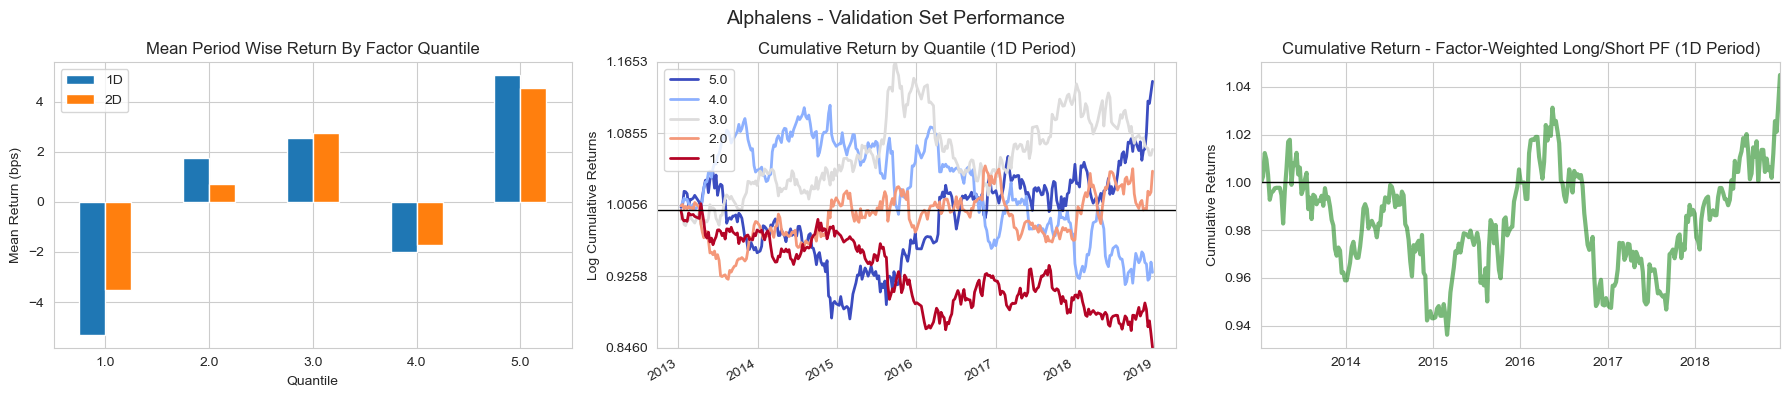

In [110]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 4))


plotting.plot_quantile_returns_bar(mean_quant_rateret, ax=axes[0])
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=0)
axes[0].set_xlabel('Quantile')

plotting.plot_cumulative_returns_by_quantile(mean_quant_ret_bydate['1D'],
                                             freq=pd.tseries.offsets.BDay(),
                                             period='1D',
                                             ax=axes[1])
axes[1].set_title('Cumulative Return by Quantile (1D Period)')

title = "Cumulative Return - Factor-Weighted Long/Short PF (1D Period)"
plotting.plot_cumulative_returns(factor_returns['1D'],
                                 period='1D',
                                 freq=pd.tseries.offsets.BDay(),
                                 title=title,
                                 ax=axes[2])

fig.suptitle('Alphalens - Validation Set Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

#### Summary Tearsheet

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1.0             -0.562140  0.952942  0.051154  0.273145    901  27.486272
2.0             -0.557394  0.954876  0.062505  0.273588    599  18.273337
3.0             -0.555397  0.956826  0.071851  0.270469    589  17.968273
4.0             -0.555029  0.964665  0.082042  0.273201    593  18.090299
5.0             -0.554491  0.968685  0.106221  0.279643    596  18.181818

Returns Analysis


1D     2D
Ann. alpha                                      0.024  0.050
beta                                            0.054  0.025
Mean Period Wise Return Top Quantile (bps)      5.065  4.557
Mean Period Wise Return Bottom Quantile (bps)  -5.304 -3.499
Mean Period Wise Spread (bps)                  10.369  7.981

Information Analysis


1D     2D
IC Mean           0.024  0.022
IC Std.           0.393  0.375
Risk-Adjusted IC  0.062  0.058
t-stat(IC)          NaN    NaN
p-value(IC)         NaN    NaN
IC Skew             NaN    NaN
IC Kurtosis         NaN    NaN

Turnover Analysis


1D     2D
Quantile 1 Mean Turnover   0.629  0.653
Quantile 2 Mean Turnover   0.766  0.805
Quantile 3 Mean Turnover   0.803  0.790
Quantile 4 Mean Turnover   0.804  0.778
Quantile 5 Mean Turnover   0.629  0.673

1D     2D
Mean Factor Rank Autocorrelation  0.257  0.176

<Figure size 640x480 with 0 Axes>

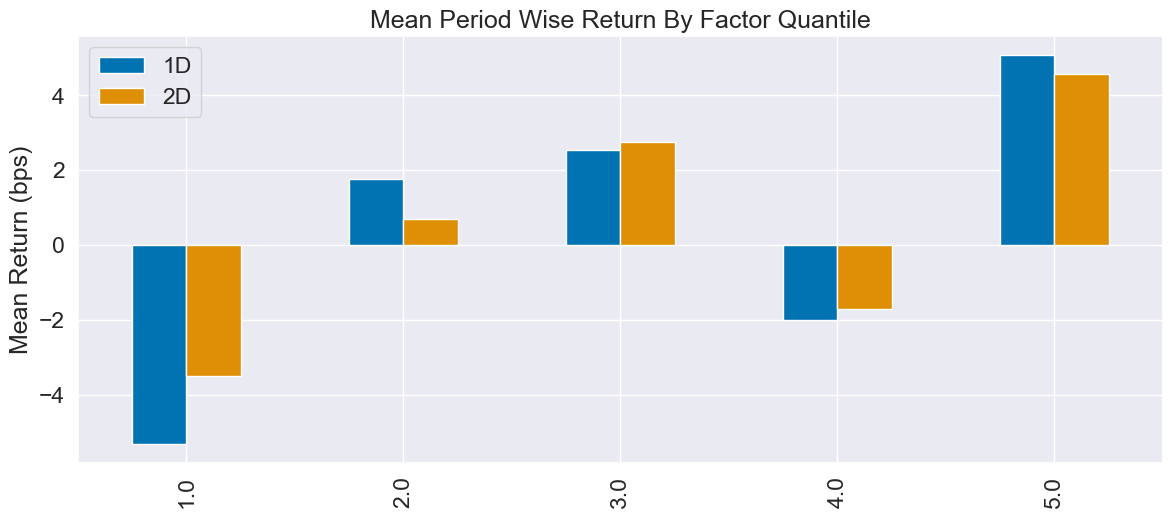

In [111]:
create_summary_tear_sheet(factor_data)

Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1.0             -0.562140  0.952942  0.051154  0.273145    901  27.486272
2.0             -0.557394  0.954876  0.062505  0.273588    599  18.273337
3.0             -0.555397  0.956826  0.071851  0.270469    589  17.968273
4.0             -0.555029  0.964665  0.082042  0.273201    593  18.090299
5.0             -0.554491  0.968685  0.106221  0.279643    596  18.181818

Returns Analysis


1D     2D
Ann. alpha                                      0.024  0.050
beta                                            0.054  0.025
Mean Period Wise Return Top Quantile (bps)      5.065  4.557
Mean Period Wise Return Bottom Quantile (bps)  -5.304 -3.499
Mean Period Wise Spread (bps)                  10.369  7.981

<Figure size 640x480 with 0 Axes>

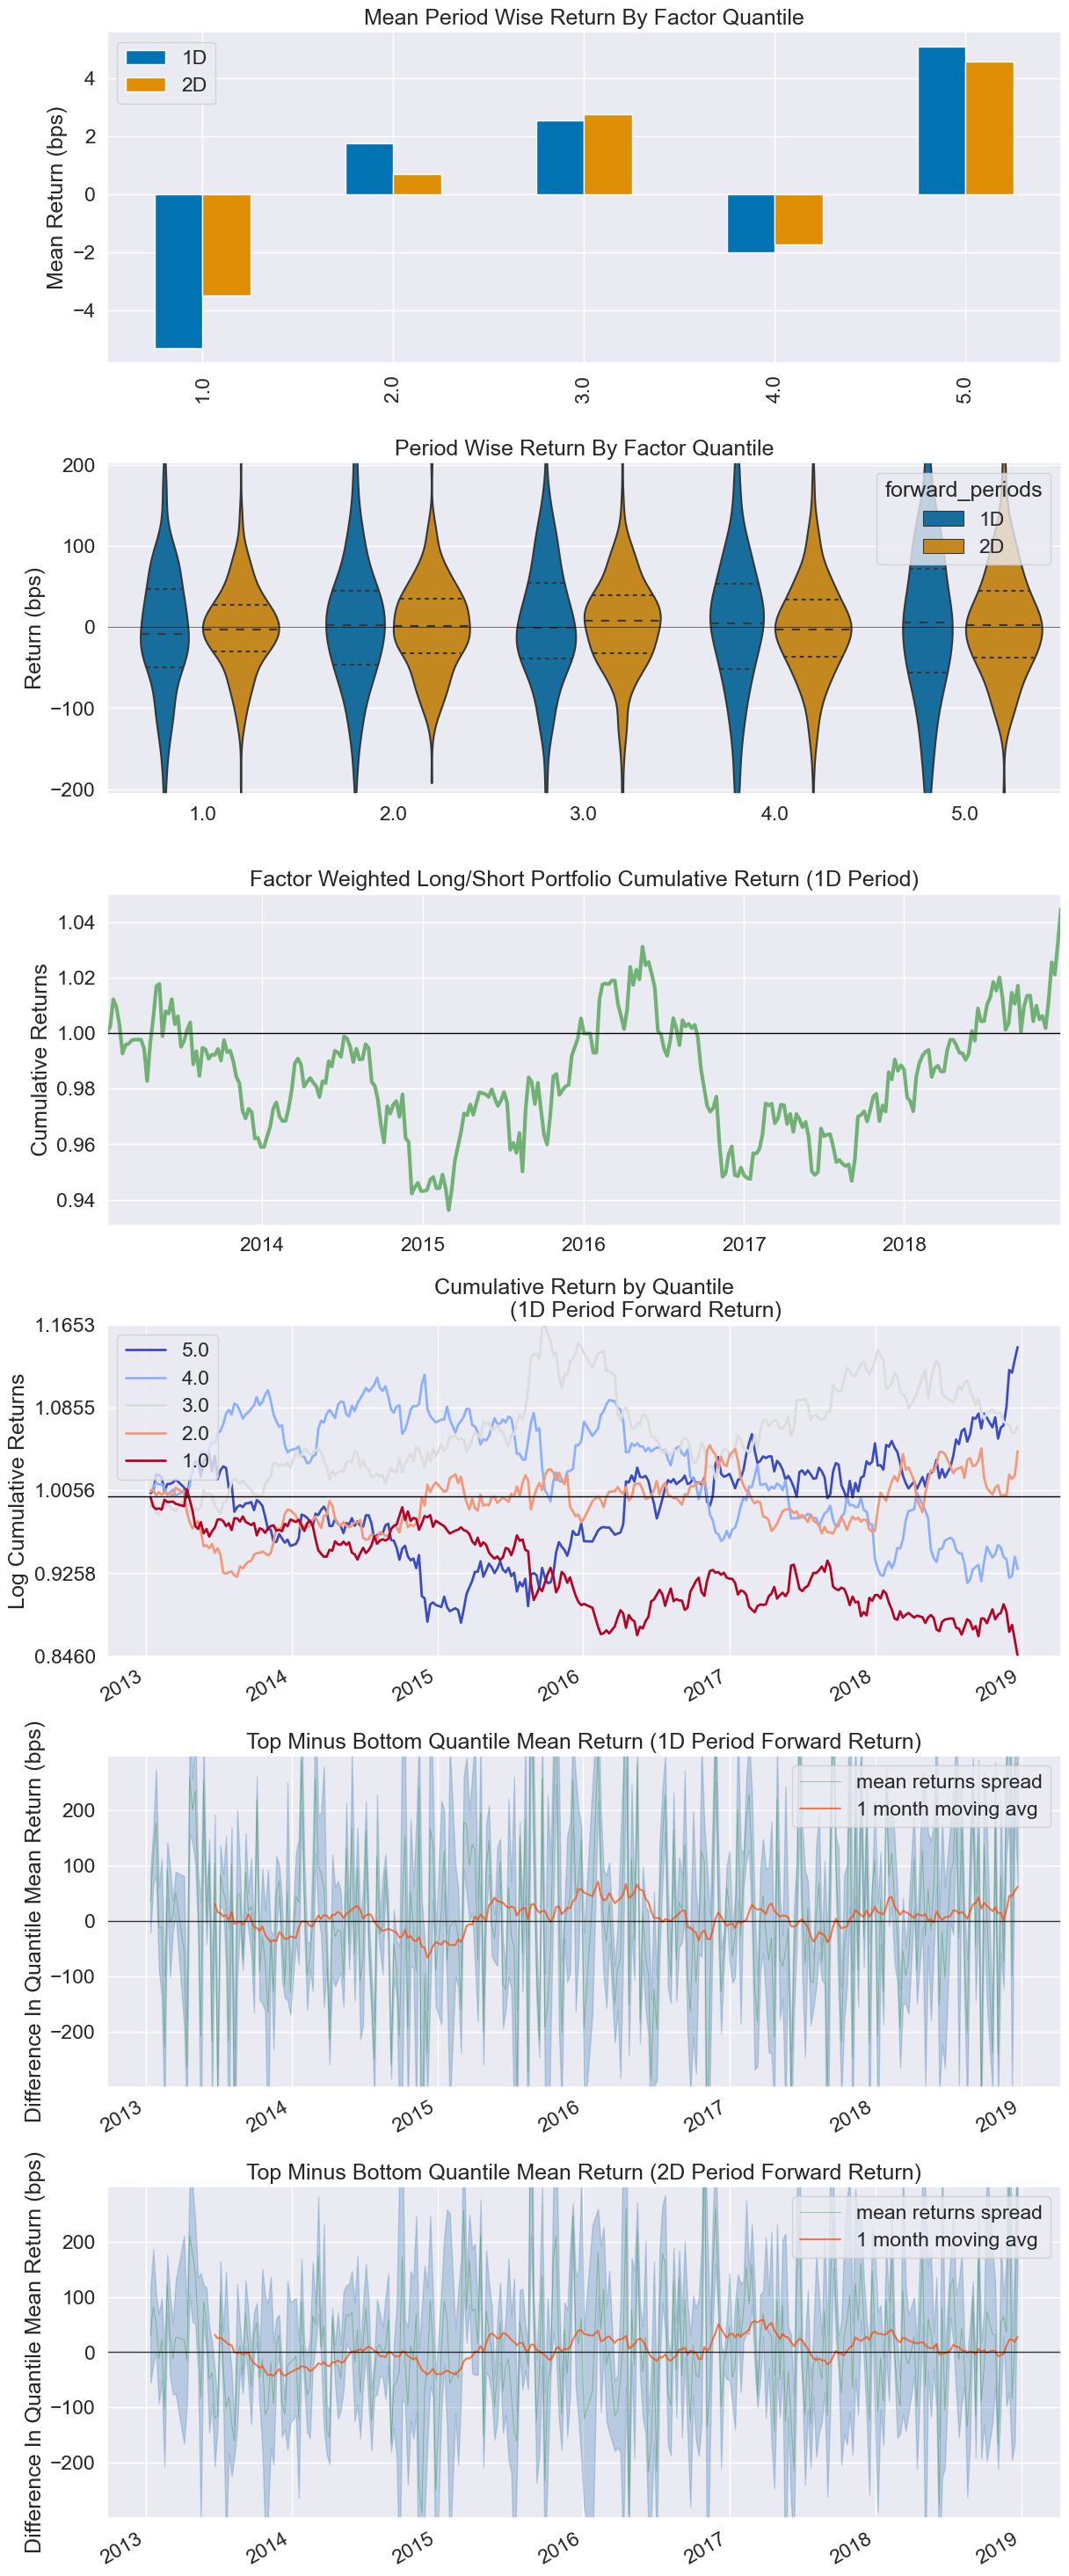

Information Analysis


1D     2D
IC Mean           0.024  0.022
IC Std.           0.393  0.375
Risk-Adjusted IC  0.062  0.058
t-stat(IC)          NaN    NaN
p-value(IC)         NaN    NaN
IC Skew             NaN    NaN
IC Kurtosis         NaN    NaN

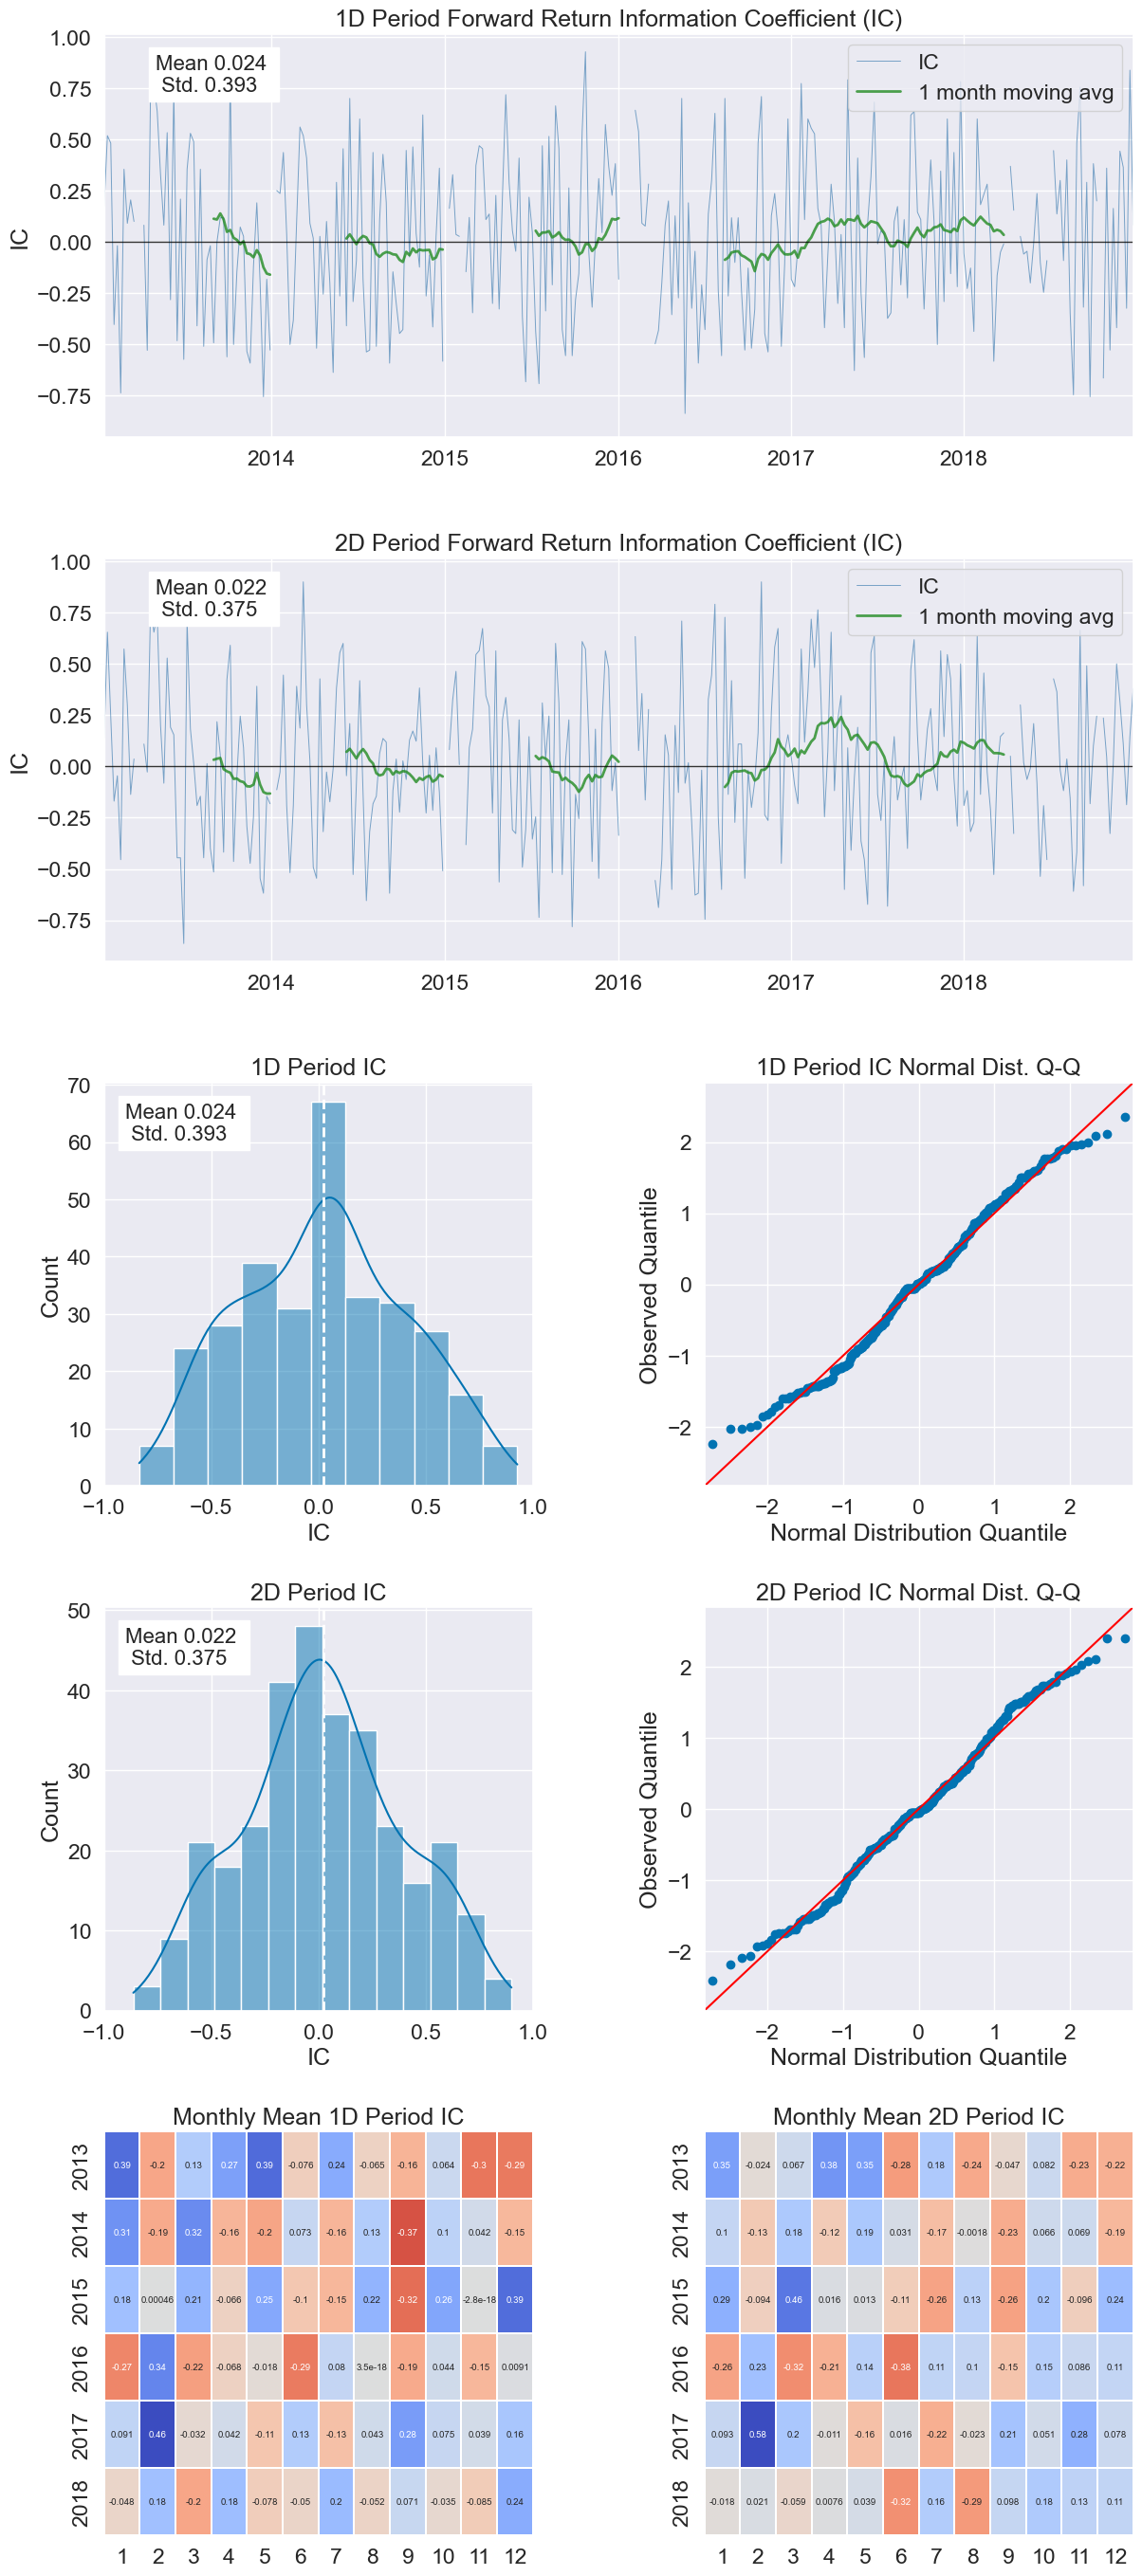

Turnover Analysis


1D     2D
Quantile 1.0 Mean Turnover   0.629  0.653
Quantile 2.0 Mean Turnover   0.766  0.805
Quantile 3.0 Mean Turnover   0.803  0.790
Quantile 4.0 Mean Turnover   0.804  0.778
Quantile 5.0 Mean Turnover   0.629  0.673

1D     2D
Mean Factor Rank Autocorrelation  0.257  0.176

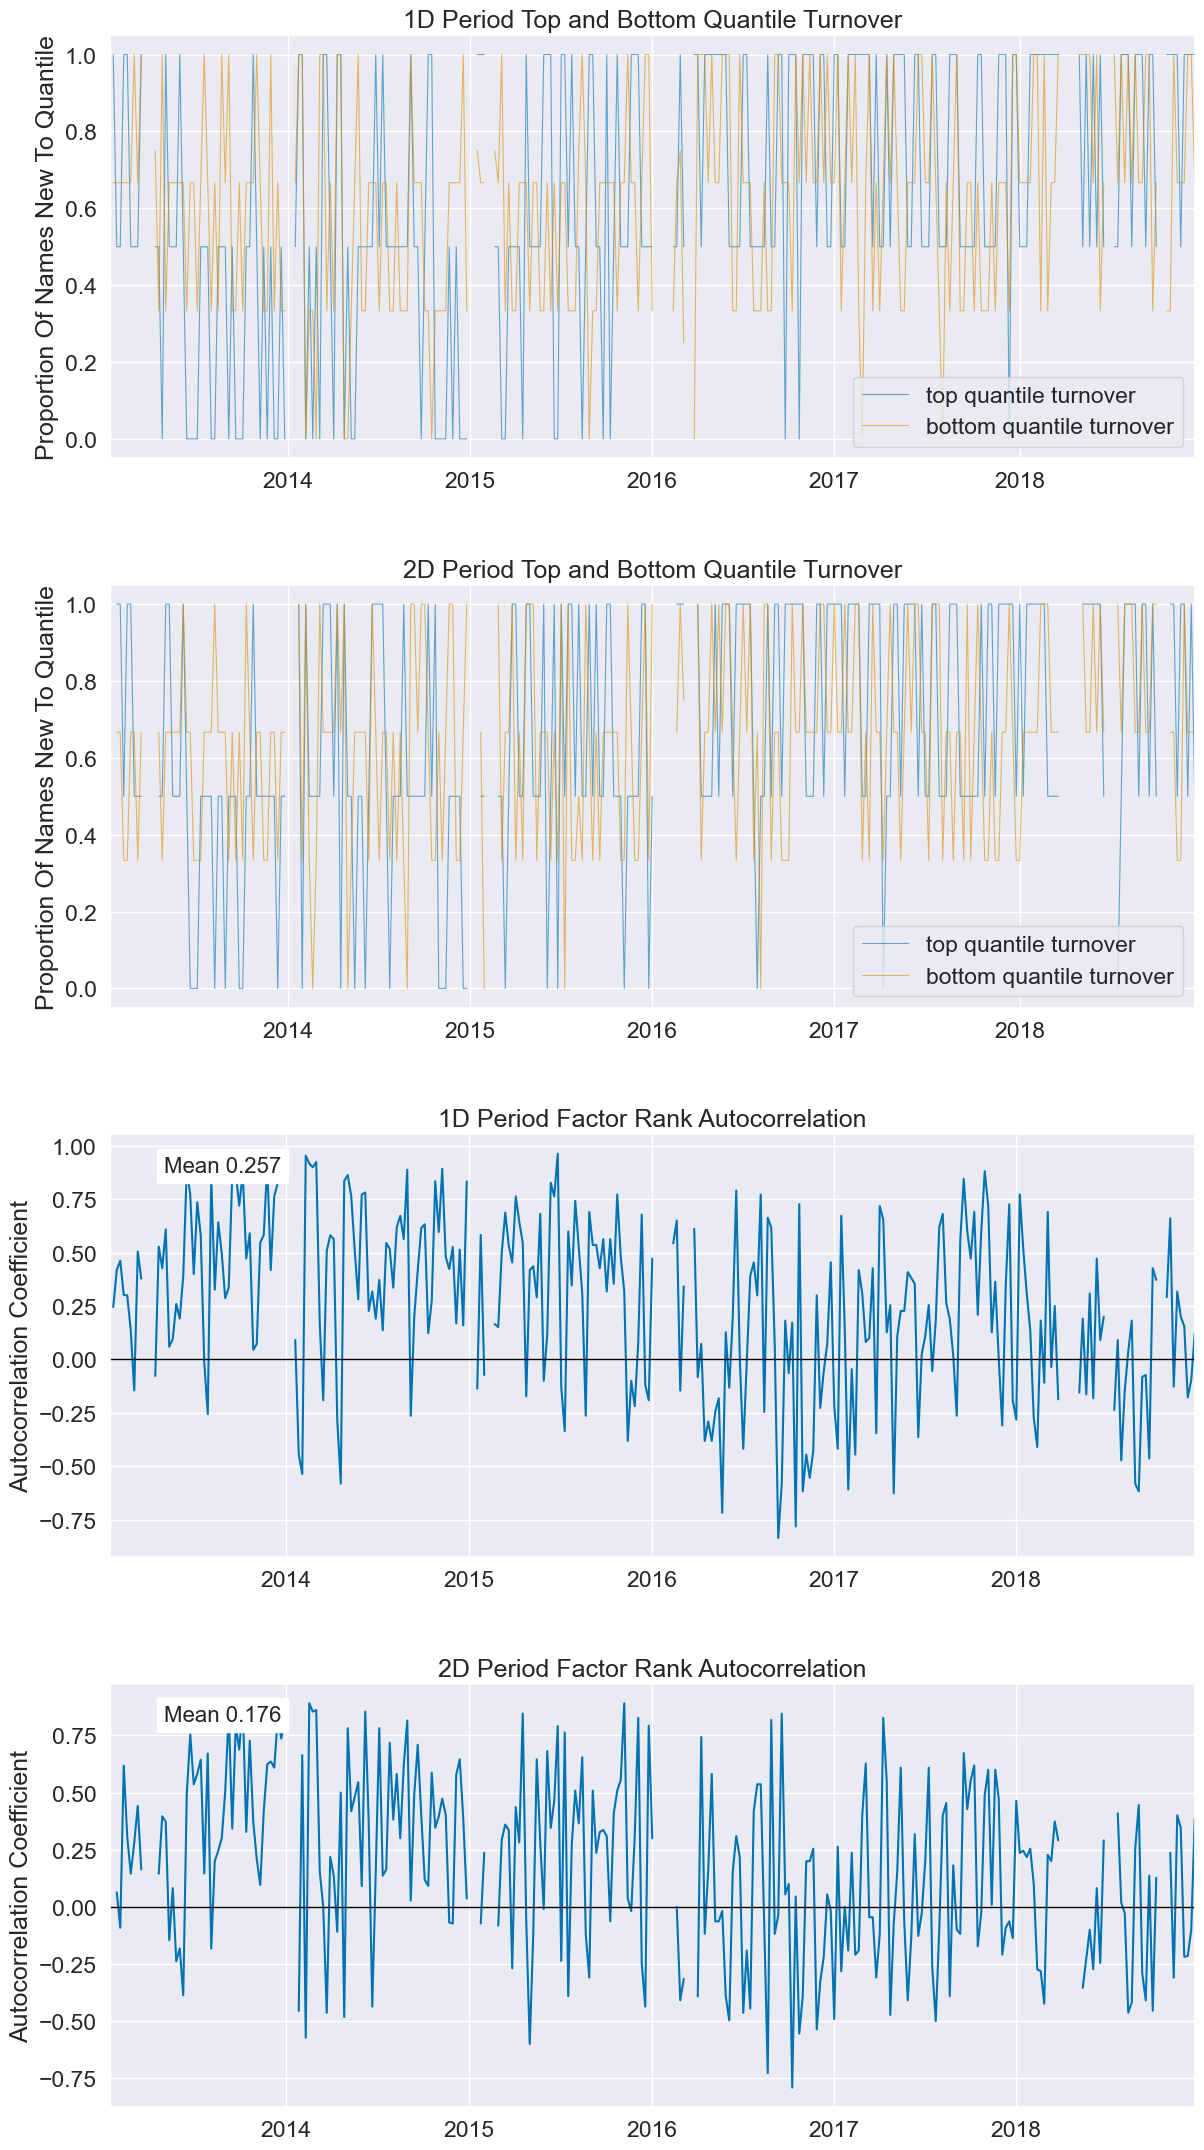

In [112]:
create_full_tear_sheet(factor_data)